<a href="https://colab.research.google.com/github/Guliko24/NetZoo_network/blob/main/GRN_30_combined_graphs_MCF7_vs_MDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import all the packages as needed
import pandas as pd
import networkx as nx

In [3]:
# prompt: let's load Gdrive onto notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Navigate to your Google Drive files
%cd /content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets


/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets


In [5]:
import numpy as np
import pandas as pd

def log_scale_dataframe(df):
    """Applies log scaling transformation to a TF-gene interaction DataFrame."""
    return np.sign(df) * np.log1p(np.abs(df))

def reverse_log_scale_dataframe(scaled_df):
    """Reverses log scaling transformation for a DataFrame."""
    return np.sign(scaled_df) * (np.expm1(np.abs(scaled_df)))


def filter_by_threshold(matrix: pd.DataFrame, threshold: float, mode: str = 'greater') -> pd.DataFrame:
    """
    Filter the matrix based on a threshold.
    Parameters:
        matrix: The TF vs Genes interaction matrix.
        threshold: The threshold value for filtering.
        mode: 'greater' to keep values greater than threshold, 'less' to keep values less than threshold.
    """
    if mode == 'greater':
        return matrix[matrix > threshold].fillna(0)
    elif mode == 'less':
        return matrix[matrix < threshold].fillna(0)
    else:
        raise ValueError("Mode must be either 'greater' or 'less'")

def binarize_matrix(matrix: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Binarize the matrix based on a threshold.
    Values greater than or equal to the threshold become 1, otherwise 0.
    """
    binary_matrix = (matrix >= threshold).astype(int)
    return binary_matrix

def rank_interactions(matrix: pd.DataFrame, top_n: int = 5) -> pd.DataFrame:
    """
    Rank the top N interactions for each transcription factor.
    Parameters:
        matrix: The TF vs Genes interaction matrix.
        top_n: Number of top interactions to return for each TF.
    """
    ranked_interactions = pd.DataFrame()
    for tf in matrix.index:
        top_genes = matrix.loc[tf].nlargest(top_n)
        ranked_interactions = pd.concat([ranked_interactions, top_genes], axis=1)
    return ranked_interactions.T

def aggregate_interactions(matrix: pd.DataFrame, axis: int = 0) -> pd.Series:
    """
    Aggregate interaction strengths.
    Parameters:
        axis: 0 to aggregate across genes (per TF), 1 to aggregate across TFs (per Gene).
    """
    return matrix.sum(axis=axis)

def construct_interaction_network(matrix: pd.DataFrame, threshold: float) -> pd.DataFrame:
    """
    Construct an interaction network by keeping only interactions above a threshold.
    Returns a DataFrame representing edges in the network.
    """
    filtered_matrix = filter_by_threshold(matrix, threshold, mode='greater')
    edges = []
    for tf in filtered_matrix.index:
        for gene in filtered_matrix.columns:
            if filtered_matrix.loc[tf, gene] > 0:
                edges.append((tf, gene, filtered_matrix.loc[tf, gene]))
    network_df = pd.DataFrame(edges, columns=['TF', 'Gene', 'Interaction_Strength'])
    return network_df

def split_positive_negative_matrices(matrix: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    Split the matrix into two DataFrames: one for positive values and one for negative values.
    Ensure that the matrix values are numeric by coercing errors and replacing non-numeric values with NaN.
    Retain the index and columns in both matrices.
    """
    matrix_numeric = matrix.apply(pd.to_numeric, errors='coerce')
    positive_matrix = matrix_numeric.where(matrix_numeric > 0).fillna(0)
    negative_matrix = matrix_numeric.where(matrix_numeric < 0).fillna(0)
    positive_matrix.index = matrix.index
    positive_matrix.columns = matrix.columns
    negative_matrix.index = matrix.index
    negative_matrix.columns = matrix.columns
    return positive_matrix, negative_matrix

def check_repeated_indices_columns(matrix: pd.DataFrame):
    """
    Check for repeated transcription factors (rows) and genes (columns) in the matrix.
    """
    repeated_rows = matrix.index[matrix.index.duplicated()].unique()
    repeated_columns = matrix.columns[matrix.columns.duplicated()].unique()

    print("Repeated Rows (TFs):")
    if len(repeated_rows) > 0:
        print(repeated_rows)
    else:
        print("No repeated rows found.")

    print("\nRepeated Columns (Genes):")
    if len(repeated_columns) > 0:
        print(repeated_columns)
    else:
        print("No repeated columns found.")



# **1. Let's process the gene expression data set GSE73857 dataset for MCF7 and MDA-MB231 cells**

*the* oridinal *gene* expression count file had ENSEMBL id for genes instead of their names, so I use R studio and Biomart package to find the gene names and add as an additional column, however it seems that there are unannotated genes which we need to remove later on.
the data set also had experimental duplicates for MCF7 and triplicates for MDA-MB231 cells so I averaged them. I could have done student-T test and find significantly different genes, but I went ahead with averaging and calculating fold-change.

In [6]:
import pandas as pd

# Load RNA-seq data
df = pd.read_csv("/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/GSE73857_MCF7_MDA_gene_expression.txt", sep="\t")  # Replace with your RNA-seq file



# Step 1: Remove the `ensembl.id` column
if "ensembl.id" in df.columns:
    df.drop(columns=["ensembl.id"], inplace=True)

# Step 2: Move the `gene_name` column to be the first column
if "gene_name" in df.columns:
    gene_name_column = df.pop("gene_name")  # Remove and retrieve `gene.name` column
    df.insert(0, "gene_name", gene_name_column)  # Insert it as the first column

# Step 3: Set `gene_name` as the index
df.set_index("gene_name", inplace=True)


# Step 1: Calculate averages
MCF7_average = df.iloc[:, [0, 1]].mean(axis=1)
MDA_MB231_average = df.iloc[:, [2, 3, 4]].mean(axis=1)

# Step 2: Drop the original columns
df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)

# Step 3: Add the new averaged columns
df["MCF7"] = MCF7_average
df["MDA-MB231"] = MDA_MB231_average

# Step 1: Remove rows where both `MCF7` and `MDA-MB231` have zero expression
MCF7_MDA_filtered_expression = df[(df["MCF7"] != 0) | (df["MDA-MB231"] != 0)]



In [7]:
MCF7_MDA_filtered_expression.head()

,MCF7,MDA-MB231
gene_name,,
TSPAN6,494.000,1198.373333
DPM1,4458.000,2367.000000
SCYL3,851.405,406.156667
FIRRM,1408.270,1153.816667
FGR,0.000,0.333333


In [8]:
MCF7_MDA_filtered_expression.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40677 entries, TSPAN6 to nan
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MCF7       40677 non-null  float64
 1   MDA-MB231  40677 non-null  float64
dtypes: float64(2)
memory usage: 953.4+ KB


# **2. Lets check whether there are differently expressed genes between two cell line so I could narrow down my graphs, by checking the fold change:**

In [9]:
import pandas as pd
import numpy as np



# Step 1: Separate rows with zero expression for further investigation
zero_expression_genes = MCF7_MDA_filtered_expression[
    (MCF7_MDA_filtered_expression['MCF7'] == 0) | (MCF7_MDA_filtered_expression['MDA-MB231'] == 0)
].copy()

# Save genes with zero expression to a new file
zero_expression_genes.to_csv("zero_expression_genes.tsv", sep="\t", index=False)

# Step 2: Filter out rows with zero expression from the original DataFrame
MCF7_MDA_filtered_expression_no_zeros = MCF7_MDA_filtered_expression[
    (MCF7_MDA_filtered_expression['MCF7'] != 0) & (MCF7_MDA_filtered_expression['MDA-MB231'] != 0)
].copy()

# Step 3: Calculate fold change and log2 fold change
MCF7_MDA_filtered_expression_no_zeros['fold_change'] =MCF7_MDA_filtered_expression_no_zeros['MDA-MB231'] / MCF7_MDA_filtered_expression_no_zeros['MCF7']
MCF7_MDA_filtered_expression_no_zeros.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
MCF7_MDA_filtered_expression_no_zeros.dropna(subset=['fold_change'], inplace=True)  # Drop rows with NaN in fold_change
MCF7_MDA_filtered_expression_no_zeros['log2_fold_change'] = np.log2(MCF7_MDA_filtered_expression_no_zeros['fold_change'])

# Step 4: Filter for significant fold change (e.g., >2 or <0.5)
significant_genes = MCF7_MDA_filtered_expression_no_zeros[
    (MCF7_MDA_filtered_expression_no_zeros['fold_change'] > 2) | (MCF7_MDA_filtered_expression_no_zeros['fold_change'] < 0.5)
]

# Save the cleaned DataFrame and significant genes to new files
MCF7_MDA_filtered_expression_no_zeros.to_csv("cleaned_gene_expression.tsv", sep="\t", index=False)
significant_genes.to_csv("significant_genes.tsv", sep="\t", index=False)

print("Files generated:")
print("1. 'zero_expression_genes.tsv' for further investigation.") #####this is an important file as it may show which genes switched on/off
print("2. 'cleaned_gene_expression.tsv' with cleaned data.")#####this is a file which has zero expression genes removed
print("3. 'significant_genes.tsv' with significant fold change.")####this is a file which as 2 fold change and 0.5 fold chane between 2 cell lines


Files generated:
1. 'zero_expression_genes.tsv' for further investigation.
2. 'cleaned_gene_expression.tsv' with cleaned data.
3. 'significant_genes.tsv' with significant fold change.


In [10]:
significant_genes.head()

,MCF7,MDA-MB231,fold_change,log2_fold_change
gene_name,,,,
TSPAN6,494.000,1198.373333,2.425857,1.278494
SCYL3,851.405,406.156667,0.477043,-1.067809
CFH,1.000,840.653333,840.653333,9.715367
STPG1,119.010,406.240000,3.413495,1.771249
NIPAL3,563.490,2629.426667,4.666324,2.222286


In [11]:
# Remove rows with NaN in the index (gene names)
# Remove rows with NaN in the index (if gene names are in the index)
significant_genes_cleaned = significant_genes[~significant_genes.index.isnull()]

# Save the cleaned significant genes to a new file
significant_genes_cleaned.to_csv("significant_genes_cleaned.tsv", sep="\t")

print("Significant genes with NaN in gene names removed. Saved to 'significant_genes_cleaned.tsv'.")


Significant genes with NaN in gene names removed. Saved to 'significant_genes_cleaned.tsv'.


In [12]:
significant_genes_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10031 entries, TSPAN6 to LOC730668
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MCF7              10031 non-null  float64
 1   MDA-MB231         10031 non-null  float64
 2   fold_change       10031 non-null  float64
 3   log2_fold_change  10031 non-null  float64
dtypes: float64(4)
memory usage: 391.8+ KB


# **3. Let's modify our TF-Gene matrices per cell line keeping only the genes found in significant_genes_cleaned**

In [13]:
#let's read the MCF7_TF_Genes dataset and make changes
df_MCF7_TF_Genes = pd.read_csv('/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ACH-000019_TF_vs_Genes_total expression.csv', index_col=0)
df_MDA_MB231_TF_Genes=pd.read_csv('/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ACH-000768.csv', index_col=0)
#df_gene_expression=pd.read_csv('/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/CCLE_expression_withinSample.csv', index_col=0)
#

In [14]:

# Step 1: Load the TF-genes matrix and the filtered gene list
#df_MCF7_TF_Genes ===matrix
#df_MDA_MB231_TF_Genes ===matrix
#MCF7_MDA_filtered_expression===gene expression file



# Extract the gene names from df_filtered
filtered_genes = set(significant_genes_cleaned.index)  # Assuming `gene_name` is the column with gene names

# Step 3: Filter the columns of the TF-genes matrix
MCF7_filtered_tf_gene_matrix = df_MCF7_TF_Genes.loc[:, df_MCF7_TF_Genes.columns.isin(filtered_genes)]
MDA_MB231_filtered_tf_gene_matrix = df_MDA_MB231_TF_Genes.loc[:, df_MDA_MB231_TF_Genes.columns.isin(filtered_genes)]



In [15]:
MCF7_filtered_tf_gene_matrix.info()
MDA_MB231_filtered_tf_gene_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, AHR to ZSCAN9
Columns: 6445 entries, A1BG to TMEM92
dtypes: float64(6445)
memory usage: 55.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, AHR to ZSCAN9
Columns: 7229 entries, A1BG to ZZZ3
dtypes: float64(7229)
memory usage: 62.4+ MB


# **4. Lets approach this slightly differently; lets rank genes based on log2_fold_change in the significant_genes_cleaned file. Then select top 300 upregulated genes and top 300 downregulated genes and only then use these for graph construction**

In [16]:
import pandas as pd


# Sort genes by log2 fold change (descending)
ranked_genes = significant_genes_cleaned.sort_values(
    by="log2_fold_change", ascending=False
)

# Save the ranked genes to a new file
ranked_genes.to_csv("ranked_significant_genes_cleaned.csv", index=False)

# Display top upregulated and downregulated genes
top_upregulated = ranked_genes.head(300)  # Top 300 overexpressed genes
top_downregulated = ranked_genes.tail(300)  # Top 300 downexpressed genes

print("Top 300 Upregulated Genes:")
print(top_upregulated)

print("\nTop 300 Downregulated Genes:")
print(top_downregulated)


Top 300 Upregulated Genes:
           MCF7    MDA-MB231  fold_change  log2_fold_change
gene_name                                                  
TNFRSF10D   0.5  2168.643333  4337.286667         12.082577
CD40        0.5  1843.333333  3686.666667         11.848101
ATP10D      0.5  1417.743333  2835.486667         11.469381
STAC        0.5  1268.000000  2536.000000         11.308339
TCEAL9      1.0  2219.333333  2219.333333         11.115911
...         ...          ...          ...               ...
GCNT2      27.5  4943.076667   179.748242          7.489834
APOL1       4.5   806.653333   179.256296          7.485880
MCAM       21.0  3759.760000   179.036190          7.484107
KLRC2       0.5    89.486667   178.973333          7.483601
ME3        12.0  2131.666667   177.638889          7.472804

[300 rows x 4 columns]

Top 300 Downregulated Genes:
               MCF7  MDA-MB231  fold_change  log2_fold_change
gene_name                                                    
HUNK        203

# **5. Filter the TF-Gene matrix to contain top 300 upregulated and top 300 downregulated genes per cell line**

In [17]:
# Ensure gene names are not used as index
if top_upregulated.index.name == 'gene_name':
    top_upregulated.reset_index(inplace=True)
if top_downregulated.index.name == 'gene_name':
    top_downregulated.reset_index(inplace=True)

In [18]:
# Combine the two lists
combined_genes_upregulated_downregulated = pd.concat([top_upregulated, top_downregulated], ignore_index=True)

combined_genes_upregulated_downregulated.head()

,gene_name,MCF7,MDA-MB231,fold_change,log2_fold_change
0,TNFRSF10D,0.5,2168.643333,4337.286667,12.082577
1,CD40,0.5,1843.333333,3686.666667,11.848101
2,ATP10D,0.5,1417.743333,2835.486667,11.469381
3,STAC,0.5,1268.000000,2536.000000,11.308339
4,TCEAL9,1.0,2219.333333,2219.333333,11.115911


In [19]:
combined_genes_upregulated_downregulated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gene_name         600 non-null    object 
 1   MCF7              600 non-null    float64
 2   MDA-MB231         600 non-null    float64
 3   fold_change       600 non-null    float64
 4   log2_fold_change  600 non-null    float64
dtypes: float64(4), object(1)
memory usage: 23.6+ KB


# The files we generate below may be important in the future if we want to split positive and negative graphs per cell line again

In [20]:
import pandas as pd
#df_MCF7_TF_Genes ===matrix
#df_MDA_MB231_TF_Genes ===matrix
#top_upregulated = ranked_genes.head(300)  # Top 300 overexpressed genes
#top_downregulated = ranked_genes.tail(300)  # Top 300 downexpressed genes



# Filter the TF-Gene matrix for upregulated genes
#MCF7_upregulated_matrix = df_MCF7_TF_Genes.loc[:, df_MCF7_TF_Genes.columns.isin(top_upregulated)]
#MDA_MB231_upregulated_matrix = df_MDA_MB231_TF_Genes.loc[:, df_MDA_MB231_TF_Genes.columns.isin(top_upregulated)]

# Filter the TF-Gene matrix for downregulated genes
#MCF7_downregulated_matrix = df_MCF7_TF_Genes.loc[:, df_MCF7_TF_Genes.columns.isin(top_downregulated)]
#MDA_MB231_downregulated_matrix = df_MDA_MB231_TF_Genes.loc[:, df_MDA_MB231_TF_Genes.columns.isin(top_downregulated)]


# Save the filtered matrices
#MCF7_upregulated_matrix.to_csv("MCF7_upregulated_tf_gene_matrix.tsv", sep="\t")
#MCF7_downregulated_matrix.to_csv("MCF7_downregulated_tf_gene_matrix.tsv", sep="\t")
#MDA_MB231_upregulated_matrix.to_csv("MDA_MB231_upregulated_tf_gene_matrix.tsv", sep="\t")
#MDA_MB231_downregulated_matrix.to_csv("MDA_MB231_downregulated_tf_gene_matrix.tsv", sep="\t")

#print("Filtered matrices saved.")


# **BUILDING GRAPHS**:
-> lets combine top 300 upregulated and top 300 downregulated genes

-> filter the Tf-gene matrix based on these genes per cell line (MCf7 and MDA_MB231)

-> build the graphs with NetworkX and visualize

-> Do GSP with PyGSP

# **1) Combine gene list and fiter the matrix**

In [21]:
import pandas as pd



# combined gene list is 'combined_genes_upregulated_downregulated'
# Filter the matrices using the combined gene list
selected_genes = combined_genes_upregulated_downregulated['gene_name'].tolist()


# Filter the matrices to keep only the selected genes as columns
filtered_matrix_mcf7_combined_edges = df_MCF7_TF_Genes.loc[:, df_MCF7_TF_Genes.columns.isin(selected_genes)]
filtered_matrix_mda_combined_edges= df_MDA_MB231_TF_Genes.loc[:, df_MDA_MB231_TF_Genes.columns.isin(selected_genes)]

# Save the filtered matrices for reference
filtered_matrix_mcf7_combined_edges.to_csv("filtered_matrix_mcf7_combined_edges.tsv", sep="\t")
filtered_matrix_mda_combined_edges.to_csv("filtered_matrix_mda_combined_edges.tsv", sep="\t")

print("Filtered matrices saved.")


Filtered matrices saved.


In [22]:
filtered_matrix_mcf7_combined_edges.head()

,ABCA12,ACKR3,ACOT4,ACSL5,ADAMTS1,ADAMTS12,ADAMTS16,ADAMTS19,ADCY1,ADCY5,...,TLR4,TM4SF1,TM4SF18,TMEM125,TMEM156,TMEM178B,TMEM26,TMEM30B,TMEM71,TMEM92
Row,,,,,,,,,,,,,,,,,,,,,
AHR,-1.089553,-0.795315,0.219303,-0.853007,0.399470,-1.630741,0.290181,-1.703381,-1.947731,-2.183788,...,-1.020596,-1.899293,-1.735155,-0.464616,-0.088311,0.546081,-1.327963,-1.899040,-1.944349,-0.818321
AHRR,-0.986674,-0.700822,0.392719,-0.701782,0.527235,-1.661367,0.493583,-1.492458,-1.692178,-1.953388,...,-1.257743,-1.675511,-1.762027,-0.336651,-0.162217,0.729568,-1.273587,-1.976856,-1.943266,-0.680559
AIRE,0.265959,-1.189028,-0.789297,1.062564,-1.320127,2.068158,-1.493547,0.400128,0.110629,1.216715,...,-0.363425,-1.296714,0.111233,-0.754813,0.276227,-0.464796,2.755469,0.743904,0.603933,-0.703877
ALX1,0.388290,-1.544013,-1.692139,-1.567756,-1.144992,0.850550,-1.189983,-1.292651,-1.751564,-1.385865,...,1.290326,-0.197852,1.397905,-2.600899,2.596896,-1.944171,1.328845,2.033929,-0.070829,-2.532883
ALX3,-1.169286,-1.528565,-1.913900,-1.577865,-1.383676,0.547645,-0.422447,-1.874142,-2.057815,-2.036447,...,1.891228,-1.729117,0.000001,-1.674775,0.283685,-1.568709,2.271090,1.326684,-0.644946,-2.533361


In [23]:
filtered_matrix_mcf7_combined_edges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, AHR to ZSCAN9
Columns: 483 entries, ABCA12 to TMEM92
dtypes: float64(483)
memory usage: 4.2+ MB


In [24]:
filtered_matrix_mda_combined_edges.head()

,ABCA12,ACKR3,ACOT4,ACSL5,ADAMTS1,ADAMTS12,ADAMTS16,ADAMTS19,ADCY1,ADCY5,...,ZNF501,ZNF502,ZNF518B,ZNF521,ZNF577,ZNF630,ZNF655,ZNF71,ZNF711,ZNF732
Row,,,,,,,,,,,,,,,,,,,,,
AHR,0.304008,-0.667807,1.200416,-0.936033,0.182179,-1.235324,-1.395829,-0.644775,-2.041014,-1.388207,...,-2.349634,-2.064601,-1.247681,-1.421086,-0.907489,-1.347365,-1.693050,-1.362386,-2.278187,0.146711
AHRR,0.247151,-0.587696,1.293375,-0.796551,0.328368,-1.308294,-1.069268,-0.484905,-1.789929,-1.243058,...,-2.141010,-2.002920,-1.431786,-1.178416,-0.893068,-1.137283,-1.451020,-1.081178,-2.225300,0.240623
AIRE,0.874790,-1.013267,0.275668,0.100357,-1.201515,2.453961,-2.109349,-0.805395,-0.436276,1.693876,...,-1.956179,1.233329,0.527247,-0.029944,0.523460,-1.969279,-2.275027,-2.057922,-0.475194,1.937781
ALX1,1.901858,-1.362818,-0.506440,-1.288876,-1.512983,1.082257,-2.706565,-0.351387,-1.688240,-0.205509,...,-3.467904,-0.405839,0.920343,-1.910685,-0.323486,-0.789209,-0.803448,-2.291393,1.893416,-0.187331
ALX3,0.740310,-1.202866,-0.330167,-1.513954,-1.692206,0.859158,-2.328144,-1.254828,-2.147329,-0.570023,...,-3.229053,0.866085,0.700537,-1.929038,-0.656320,-1.514953,-2.219323,-2.912750,2.325852,0.511644


In [25]:
filtered_matrix_mda_combined_edges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, AHR to ZSCAN9
Columns: 535 entries, ABCA12 to ZNF732
dtypes: float64(535)
memory usage: 4.6+ MB


# We still have 1132 entries for TFs, let's trim this down based on the article we found at https://www.academia.edu/62149166/Identification_of_novel_dysregulated_key_genes_in_Breast_cancer_through_high_throughput_ChIP_Seq_data_analysis .
# I have generated a csv file with 20 TF from this article and added CTCF to the list as I have an interest in it

In [26]:
import pandas as pd
import os

# File paths
tf_file = "/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/Breast_Cancer_TFs.csv"
ppi_file = "/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ppi_complete.txt"
output_file = "filtered_ppi.tsv"

# Validate file paths
if not os.path.exists(tf_file):
    raise FileNotFoundError(f"TF file not found: {tf_file}")
if not os.path.exists(ppi_file):
    raise FileNotFoundError(f"PPI file not found: {ppi_file}")

# Load the TF file (CSV format)
print(f"Loading TF file: {tf_file}")
tf_df = pd.read_csv(tf_file)

# Check if the expected column exists
if 'Gene/Transcription Factor' not in tf_df.columns:
    raise KeyError("Column 'Gene/Transcription Factor' not found in TF file.")

# Get the list of transcription factors
tf_list = tf_df['Gene/Transcription Factor'].str.strip().str.upper().tolist()

# Load the PPI file (TXT format)
print(f"Loading PPI file: {ppi_file}")
ppi_df = pd.read_csv(ppi_file, sep="\t", header=None, names=["Protein1", "Protein2", "InteractionStrength"])

# Ensure the expected columns are present
if not all(col in ppi_df.columns for col in ["Protein1", "Protein2", "InteractionStrength"]):
    raise KeyError("Columns 'Protein1', 'Protein2', or 'InteractionStrength' not found in PPI file.")

# Convert PPI proteins to uppercase for case-insensitive matching
ppi_df['Protein1'] = ppi_df['Protein1'].str.strip().str.upper()
ppi_df['Protein2'] = ppi_df['Protein2'].str.strip().str.upper()


# Filter the PPI dataframe to retain rows where Protein1  in the TF list
print("Filtering PPI data...")
filtered_ppi_df = ppi_df[
    (ppi_df['Protein1'].isin(tf_list))
]

#lets try to remove zero interactions to see how small the file will be
filtered_ppi_minus_zero_df = filtered_ppi_df[filtered_ppi_df['InteractionStrength'] != 0]

# Reset the index after filtering
filtered_ppi_minus_zero_df.reset_index(drop=True, inplace=True)
# Save the filtered PPI to a new file
#print(f"Saving filtered PPI to file: {output_file}")
filtered_ppi_df.to_csv(output_file, sep="\t", index=False, header=True)
filtered_ppi_minus_zero_df.to_csv("filtered_ppi_minus_zero.tsv", sep="\t", index=False, header=True)
print(f"Filtered PPI file saved successfully to {output_file}")


Loading TF file: /content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/Breast_Cancer_TFs.csv
Loading PPI file: /content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/MCF7_raw/ppi_complete.txt
Filtering PPI data...
Filtered PPI file saved successfully to filtered_ppi.tsv


In [27]:
tf_list

['SOX2',
 'PPRAG',
 'CREB1',
 'STAT5A',
 'NR2C2',
 'LEF1',
 'CREBBP',
 'ZBED1',
 'RXRA',
 'ATF1',
 'MAFA',
 'ZNF766',
 'NFKB1',
 'NFKB2',
 'REL',
 'CENPB',
 'NPAS4',
 'ZBTB7A',
 'PATZ1',
 'MZF1',
 'CTCF']

## Lets trim our matrices so that they contain the list of TFs from filtered_ppi_minus_zero.df file

# Lets filter matrix on 20TF and its interacting partners

# **For MCF7 and MDA**

In [28]:
import pandas as pd

# Assuming you have already loaded your TF-gene matrix and PPI data frame
# tf_gene_matrix is your TF-gene matrix
# filtered_ppi_minus_zero_df is your PPI data frame
#HERE I decided to expand a little and pull out 18TFs from both protein1 or protein2 in ppi file

# Step 1: Extract unique TFs from both Protein1 and Protein2 columns
unique_tfs_protein1 = filtered_ppi_minus_zero_df['Protein1'].unique()
unique_tfs_protein2 = filtered_ppi_minus_zero_df['Protein2'].unique()

# Step 2: Combine the two lists and remove duplicates
unique_tfs = pd.unique(np.concatenate([unique_tfs_protein1, unique_tfs_protein2]))

# Step 3: Filter the TF-gene matrix to include only rows where the index (TF names) is in unique_tfs
filtered_matrix_mcf7_combined_edges_ppi_TFs = filtered_matrix_mcf7_combined_edges[filtered_matrix_mcf7_combined_edges.index.isin(unique_tfs)]

#Step 4: Name the index column as 'TF'
filtered_matrix_mcf7_combined_edges_ppi_TFs.index.name = 'TF'

# Step 5: Reset the index to make 'TF' a regular column
filtered_matrix_mcf7_combined_edges_ppi_TFs = filtered_matrix_mcf7_combined_edges_ppi_TFs.reset_index()

# Now filtered_tf_gene_matrix contains only the TFs mentioned in either Protein1 or Protein2 of the PPI file
#print(filtered_matrix_mcf7_combined_edges_ppi_TFs)
filtered_matrix_mcf7_combined_edges_ppi_TFs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Columns: 484 entries, TF to TMEM92
dtypes: float64(483), object(1)
memory usage: 3.2+ MB


In [29]:
import pandas as pd

# Assuming you have already loaded your TF-gene matrix and PPI data frame
# tf_gene_matrix is your TF-gene matrix
# filtered_ppi_minus_zero_df is your PPI data frame
#HERE I decided to expand a little and pull out 18TFs from both protein1 or protein2 in ppi file

# Step 1: Extract unique TFs from both Protein1 and Protein2 columns
unique_tfs_protein1 = filtered_ppi_minus_zero_df['Protein1'].unique()
unique_tfs_protein2 = filtered_ppi_minus_zero_df['Protein2'].unique()

# Step 2: Combine the two lists and remove duplicates
unique_tfs = pd.unique(np.concatenate([unique_tfs_protein1, unique_tfs_protein2]))

# Step 3: Filter the TF-gene matrix to include only rows where the index (TF names) is in unique_tfs
filtered_matrix_mda_combined_edges_ppi_TFs = filtered_matrix_mda_combined_edges[filtered_matrix_mda_combined_edges.index.isin(unique_tfs)]

#Step 4: Name the index column as 'TF'
filtered_matrix_mda_combined_edges_ppi_TFs.index.name = 'TF'

# Step 5: Reset the index to make 'TF' a regular column
filtered_matrix_mda_combined_edges_ppi_TFs = filtered_matrix_mda_combined_edges_ppi_TFs.reset_index()

# Now filtered_tf_gene_matrix contains only the TFs mentioned in either Protein1 or Protein2 of the PPI file
#print(filtered_matrix_mda_combined_edges_ppi_TFs)
filtered_matrix_mda_combined_edges_ppi_TFs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Columns: 536 entries, TF to ZNF732
dtypes: float64(535), object(1)
memory usage: 3.5+ MB


In [30]:
filtered_matrix_mda_combined_edges_ppi_TFs.head()

,TF,ABCA12,ACKR3,ACOT4,ACSL5,ADAMTS1,ADAMTS12,ADAMTS16,ADAMTS19,ADCY1,...,ZNF501,ZNF502,ZNF518B,ZNF521,ZNF577,ZNF630,ZNF655,ZNF71,ZNF711,ZNF732
0,AHR,0.304008,-0.667807,1.200416,-0.936033,0.182179,-1.235324,-1.395829,-0.644775,-2.041014,...,-2.349634,-2.064601,-1.247681,-1.421086,-0.907489,-1.347365,-1.693050,-1.362386,-2.278187,0.146711
1,AHRR,0.247151,-0.587696,1.293375,-0.796551,0.328368,-1.308294,-1.069268,-0.484905,-1.789929,...,-2.141010,-2.002920,-1.431786,-1.178416,-0.893068,-1.137283,-1.451020,-1.081178,-2.225300,0.240623
2,AIRE,0.874790,-1.013267,0.275668,0.100357,-1.201515,2.453961,-2.109349,-0.805395,-0.436276,...,-1.956179,1.233329,0.527247,-0.029944,0.523460,-1.969279,-2.275027,-2.057922,-0.475194,1.937781
3,ALX1,1.901858,-1.362818,-0.506440,-1.288876,-1.512983,1.082257,-2.706565,-0.351387,-1.688240,...,-3.467904,-0.405839,0.920343,-1.910685,-0.323486,-0.789209,-0.803448,-2.291393,1.893416,-0.187331
4,ALX3,0.740310,-1.202866,-0.330167,-1.513954,-1.692206,0.859158,-2.328144,-1.254828,-2.147329,...,-3.229053,0.866085,0.700537,-1.929038,-0.656320,-1.514953,-2.219323,-2.912750,2.325852,0.511644


In [31]:
filtered_matrix_mcf7_combined_edges_ppi_TFs.head()

,TF,ABCA12,ACKR3,ACOT4,ACSL5,ADAMTS1,ADAMTS12,ADAMTS16,ADAMTS19,ADCY1,...,TLR4,TM4SF1,TM4SF18,TMEM125,TMEM156,TMEM178B,TMEM26,TMEM30B,TMEM71,TMEM92
0,AHR,-1.089553,-0.795315,0.219303,-0.853007,0.399470,-1.630741,0.290181,-1.703381,-1.947731,...,-1.020596,-1.899293,-1.735155,-0.464616,-0.088311,0.546081,-1.327963,-1.899040,-1.944349,-0.818321
1,AHRR,-0.986674,-0.700822,0.392719,-0.701782,0.527235,-1.661367,0.493583,-1.492458,-1.692178,...,-1.257743,-1.675511,-1.762027,-0.336651,-0.162217,0.729568,-1.273587,-1.976856,-1.943266,-0.680559
2,AIRE,0.265959,-1.189028,-0.789297,1.062564,-1.320127,2.068158,-1.493547,0.400128,0.110629,...,-0.363425,-1.296714,0.111233,-0.754813,0.276227,-0.464796,2.755469,0.743904,0.603933,-0.703877
3,ALX1,0.388290,-1.544013,-1.692139,-1.567756,-1.144992,0.850550,-1.189983,-1.292651,-1.751564,...,1.290326,-0.197852,1.397905,-2.600899,2.596896,-1.944171,1.328845,2.033929,-0.070829,-2.532883
4,ALX3,-1.169286,-1.528565,-1.913900,-1.577865,-1.383676,0.547645,-0.422447,-1.874142,-2.057815,...,1.891228,-1.729117,0.000001,-1.674775,0.283685,-1.568709,2.271090,1.326684,-0.644946,-2.533361


In [32]:
import numpy as np
import pandas as pd

def normalize_to_neg1_pos1(df):
    """Normalizes TF-gene interaction strengths to the range [-1,1], keeping the TF column intact."""
    df_normalized = df.copy()
    numeric_data = df.iloc[:, 1:]  # Exclude TF names

    w_min, w_max = numeric_data.min().min(), numeric_data.max().max()

    # Apply min-max normalization to [-1,1]
    df_normalized.iloc[:, 1:] = 2 * (numeric_data - w_min) / (w_max - w_min) - 1

    return df_normalized, w_min, w_max  # Return min/max for reversibility

def denormalize_from_neg1_pos1(df_normalized, w_min, w_max):
    """Reverses the normalization process to restore original values."""
    df_recovered = df_normalized.copy()
    df_recovered.iloc[:, 1:] = ((df_recovered.iloc[:, 1:] + 1) * (w_max - w_min) / 2) + w_min
    return df_recovered




In [33]:
#lets normalize the MCF7 and MDA matrices
# Example usage
df_normalized_MCF7, w_min, w_max = normalize_to_neg1_pos1(filtered_matrix_mcf7_combined_edges_ppi_TFs)
print("Normalized DataFrame  MCF7 (-1 to 1):\n", df_normalized_MCF7.head())

df_recovered_MCF7= denormalize_from_neg1_pos1(df_normalized_MCF7, w_min, w_max)
print("\nRecovered DataFrame MCF7 :\n", df_recovered_MCF7.head())

# Verify accuracy
assert np.allclose(filtered_matrix_mcf7_combined_edges_ppi_TFs.iloc[:, 1:].values,
                   df_recovered_MCF7.iloc[:, 1:].values, atol=1e-6)

df_normalized_MDA, w_min, w_max = normalize_to_neg1_pos1(filtered_matrix_mda_combined_edges_ppi_TFs)
print("Normalized DataFrame MDA (-1 to 1):\n", df_normalized_MCF7.head())
df_recovered_MDA= denormalize_from_neg1_pos1(df_normalized_MDA, w_min, w_max)
print("\nRecovered DataFrame MDA:\n", df_recovered_MDA.head())

# Verify accuracy
assert np.allclose(filtered_matrix_mda_combined_edges_ppi_TFs.iloc[:, 1:].values,
                   df_recovered_MDA.iloc[:, 1:].values, atol=1e-6)



Normalized DataFrame  MCF7 (-1 to 1):
      TF    ABCA12     ACKR3     ACOT4     ACSL5   ADAMTS1  ADAMTS12  ADAMTS16  \
0   AHR  0.067639  0.083570  0.138503  0.080446  0.148258  0.038339  0.142340   
1  AHRR  0.073209  0.088686  0.147892  0.088634  0.155175  0.036680  0.153353   
2  AIRE  0.141029  0.062254  0.083896  0.184159  0.055156  0.238603  0.045766   
3  ALX1  0.147652  0.043034  0.035014  0.041749  0.064638  0.172680  0.062202   
4  ALX3  0.063322  0.043870  0.023008  0.041201  0.051715  0.156280  0.103758   

   ADAMTS19     ADCY1  ...      TLR4    TM4SF1   TM4SF18   TMEM125   TMEM156  \
0  0.034406  0.021176  ...  0.071373  0.023799  0.032685  0.101474  0.121848   
1  0.045825  0.035012  ...  0.058533  0.035915  0.031230  0.108403  0.117847   
2  0.148293  0.132619  ...  0.106953  0.056423  0.132652  0.085763  0.141585   
3  0.056643  0.031797  ...  0.196490  0.115918  0.202315 -0.014187  0.267230   
4  0.025160  0.015216  ...  0.229024  0.033012  0.126630  0.035954  0.1419

Let's load the ppi file and add it to the graphs

In [34]:
import pandas as pd

# Load the PPI file
ppi_file = "/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/filtered_ppi_minus_zero.tsv"  # Replace with your file path
ppi_df = pd.read_csv(ppi_file, sep="\t")  # Adjust separator if needed

# Inspect the PPI DataFrame
print(ppi_df.head())

  Protein1 Protein2  InteractionStrength
0     ATF1    AKAP8                0.156
1     ATF1       AR                0.352
2     ATF1     ARNT                0.153
3     ATF1    ASH1L                0.269
4     ATF1     ATF2                0.905


# **2. Build Graphs with Annonated Edges for each cell line** using min-max normalized matrix

**MCF7** **GRAPH**

In [35]:
import networkx as nx


# Create a directed graph for MCF7
G_mcf7 = nx.DiGraph()

# Check if 'TF' is the index and reset it if necessary
if 'TF' not in df_normalized_MCF7.columns:
    df_normalized_MCF7 = df_normalized_MCF7.reset_index()

# Iterate over rows in the DataFrame
for _, row in df_normalized_MCF7.iterrows():
    tf = row['TF']  # Transcription factor (First column)

    # Iterate through all genes (ignoring the first column)
    for gene, weight in row.iloc[1:].items():
        if weight > 0:
            edge_type = "positive"  # Activation
        elif weight < 0:
            edge_type = "negative"  # Repression
        else:
            continue  # Skip zero values

        # Add edge to the graph
        G_mcf7.add_edge(tf, gene, weight=weight, type=edge_type)


**MDA_MB231 GRAPH**

In [36]:
import networkx as nx


# Create a directed graph for MDA
G_mda = nx.DiGraph()

# Check if 'TF' is the index and reset it if necessary
if 'TF' not in df_normalized_MDA.columns:
    df_normalized_MDA = df_normalized_MDA.reset_index()

# Iterate over rows in the DataFrame
for _, row in df_normalized_MDA.iterrows():
    tf = row['TF']  # Transcription factor (First column)

    # Iterate through all genes (ignoring the first column)
    for gene, weight in row.iloc[1:].items():
        if weight > 0:
            edge_type = "positive"  # Activation
        elif weight < 0:
            edge_type = "negative"  # Repression
        else:
            continue  # Skip zero values

        # Add edge to the graph
        G_mda.add_edge(tf, gene, weight=weight, type=edge_type)

Let's try adding the ppi file to the existing graphs


In [37]:
import networkx as nx

# Ensure the graph is directed (if applicable)
G_mcf7_ppi= G_mcf7  # Replace with G_mda if working with MDA-MB-231

# Add PPI interactions to the graph
for _, row in ppi_df.iterrows():
    protein1 = row["Protein1"]
    protein2 = row["Protein2"]
    interaction_strength = row.get("InteractionStrength", 1.0)  # Default to 1.0 if no strength column exists

    # Only add edges if both proteins exist in the graph
    if G_mcf7_ppi.has_node(protein1) and G_mcf7_ppi.has_node(protein2):
        G_mcf7_ppi.add_edge(protein1, protein2, weight=interaction_strength)

print(f"Added PPI interactions for existing nodes only.")

Added PPI interactions for existing nodes only.


In [38]:
import networkx as nx

# Ensure the graph is directed (if applicable)
G_mda_ppi= G_mda  # Replace with G_mda if working with MDA-MB-231

# Add PPI interactions to the graph
for _, row in ppi_df.iterrows():
    protein1 = row["Protein1"]
    protein2 = row["Protein2"]
    interaction_strength = row.get("InteractionStrength", 1.0)  # Default to 1.0 if no strength column exists

    # Only add edges if both proteins exist in the graph
    if G_mda_ppi.has_node(protein1) and G_mda_ppi.has_node(protein2):
        G_mda_ppi.add_edge(protein1, protein2, weight=interaction_strength)

print(f"Added PPI interactions for existing nodes only.")

Added PPI interactions for existing nodes only.


# **3. Visualize Graphs**

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(graph, title):
    # Define edge colors based on annotations
    edge_colors = [
        "green" if graph[u][v]['type'] == "positive" else "red"
        for u, v in graph.edges
    ]

    # Draw the graph
    pos = nx.spring_layout(graph, seed=42)  # Spring layout for better visualization
    nx.draw(
        graph, pos, with_labels=True, edge_color=edge_colors, node_size=500, font_size=10
    )

    # Add a legend for edge colors
    plt.title(title)
    plt.show()

# Load the graphs
#G_mcf7_ppi = nx.read_graphml("mcf7_graph_with_annotations.graphml")
#G_mda_ppi = nx.read_graphml("mda_mb231_graph_with_annotations.graphml")

# Visualize MCF7 graph
#visualize_graph(G_mcf7, "MCF7 Graph")

# Visualize MDA-MB231 graph
#visualize_graph(G_mda, "MDA-MB231 Graph")


LETS CONTINUE WITH BASIC GRAPH ANALYSIS:

1) **Analyze** **basic** **graph** **properties**

In [40]:
# Number of Nodes and Edges
num_nodes_mcf7 = G_mcf7.number_of_nodes()
num_edges_mcf7 = G_mcf7.number_of_edges()
print(f"Number of nodes MCF7: {num_nodes_mcf7}")
print(f"Number of edges MCF7: {num_edges_mcf7}")

num_nodes_mda = G_mda.number_of_nodes()
num_edges_mda = G_mda.number_of_edges()
print(f"Number of nodes MDA: {num_nodes_mda}")
print(f"Number of edges MDA: {num_edges_mda}")

Number of nodes MCF7: 1309
Number of edges MCF7: 418852
Number of nodes MDA: 1354
Number of edges MDA: 463501


In [41]:
# Number of Nodes and Edges with added ppi file
num_nodes_mcf7 = G_mcf7_ppi.number_of_nodes()
num_edges_mcf7 = G_mcf7_ppi.number_of_edges()
print(f"Number of nodes MCF7 with ppi: {num_nodes_mcf7}")
print(f"Number of edges MCF7 with ppi: {num_edges_mcf7}")

num_nodes_mda = G_mda_ppi.number_of_nodes()
num_edges_mda = G_mda_ppi.number_of_edges()
print(f"Number of nodes MDA with ppi: {num_nodes_mda}")
print(f"Number of edges MDA with ppi: {num_edges_mda}")

Number of nodes MCF7 with ppi: 1309
Number of edges MCF7 with ppi: 418852
Number of nodes MDA with ppi: 1354
Number of edges MDA with ppi: 463501


In [42]:
# density= measure how dense is the graph
density_mcf7 = nx.density(G_mcf7)
print(f"Density MCF7: {density_mcf7}")

density_mda = nx.density(G_mda)
print(f"Density MDA: {density_mda}")

Density MCF7: 0.24463196454561809
Density MDA: 0.2530079772397026


In [43]:
# density= measure how dense is the graph
density_mcf7_ppi = nx.density(G_mcf7_ppi)
print(f"Density MCF7 with ppi: {density_mcf7_ppi}")

density_mda_ppi = nx.density(G_mda_ppi)
print(f"Density MDA with ppi: {density_mda_ppi}")

Density MCF7 with ppi: 0.24463196454561809
Density MDA with ppi: 0.2530079772397026


In [44]:
#connected components= check if the graph is weakly or strongly connected
is_weakly_connected_mcf7 = nx.is_weakly_connected(G_mcf7)
is_strongly_connected_mcf7 = nx.is_strongly_connected(G_mcf7)
print(f"Weakly connected MCF7: {is_weakly_connected_mcf7}")
print(f"Strongly connected MCF7 : {is_strongly_connected_mcf7}")


is_weakly_connected_mda = nx.is_weakly_connected(G_mda)
is_strongly_connected_mda = nx.is_strongly_connected(G_mda)
print(f"Weakly connected MDA: {is_weakly_connected_mda}")
print(f"Strongly connected MDA : {is_strongly_connected_mda}")


Weakly connected MCF7: True
Strongly connected MCF7 : False
Weakly connected MDA: True
Strongly connected MDA : False


In [45]:
#connected components= check if the graph is weakly or strongly connected
is_weakly_connected_mcf7_ppi = nx.is_weakly_connected(G_mcf7_ppi)
is_strongly_connected_mcf7_ppi = nx.is_strongly_connected(G_mcf7_ppi)
print(f"Weakly connected MCF7 with ppi: {is_weakly_connected_mcf7_ppi}")
print(f"Strongly connected MCF7 with ppi : {is_strongly_connected_mcf7_ppi}")


is_weakly_connected_mda_ppi = nx.is_weakly_connected(G_mda_ppi)
is_strongly_connected_mda_ppi = nx.is_strongly_connected(G_mda_ppi)
print(f"Weakly connected MDA with ppi: {is_weakly_connected_mda_ppi}")
print(f"Strongly connected MDA with ppi: {is_strongly_connected_mda_ppi}")


Weakly connected MCF7 with ppi: True
Strongly connected MCF7 with ppi : False
Weakly connected MDA with ppi: True
Strongly connected MDA with ppi: False


In [46]:
#Shortest path= analyze the shortest paths between nodes
shortest_path_lengths_mcf7_ppi = dict(nx.shortest_path_length(G_mcf7_ppi))
shortest_path_lengths_mda_ppi = dict(nx.shortest_path_length(G_mda_ppi))


# 2. Identify Suppopulations(Communities or Clusters)
Subpopulations in a graph often refer to communities or clusters of nodes that are more densely connected among themselves than with the rest of the graph.:

In [47]:
#A)Weakly Connected Components:
#For directed graphs, weakly connected components are subgraphs where nodes are connected regardless of edge direction.
weakly_connected_components_mcf7_ppi= list(nx.weakly_connected_components(G_mcf7_ppi))
print(f"Number of weakly connected components MCF7 with ppi: {len(weakly_connected_components_mcf7_ppi)}")
weakly_connected_components_mda_ppi = list(nx.weakly_connected_components(G_mda_ppi))
print(f"Number of weakly connected components MDA  with ppi: {len(weakly_connected_components_mda_ppi)}")



Number of weakly connected components MCF7 with ppi: 1
Number of weakly connected components MDA  with ppi: 1


In [48]:
#B)Strongly Connected Components:
#    Strongly connected components are subgraphs where every node is reachable from every other node, following edge directions.#
strongly_connected_components_mcf7_ppi= list(nx.strongly_connected_components(G_mcf7_ppi))
print(f"Number of strongly connected components MCF7: {len(strongly_connected_components_mcf7_ppi)}")
strongly_connected_components_mda_ppi= list(nx.strongly_connected_components(G_mda_ppi))
print(f"Number of strongly connected components MDA: {len(strongly_connected_components_mda_ppi)}")

Number of strongly connected components MCF7: 452
Number of strongly connected components MDA: 497


In [49]:
#D)K-Cores:

#Identify k-cores, which are subgraphs where each node has at least degree k.
G_mcf7_ppi.remove_edges_from(nx.selfloop_edges(G_mcf7_ppi)) # Remove self-loops from G_mcf7
k_cores_mcf7_ppi = nx.k_core(G_mcf7_ppi)
print(f"Number of k-cores in MCF7: {k_cores_mcf7_ppi.number_of_nodes()}")

G_mda_ppi.remove_edges_from(nx.selfloop_edges(G_mda_ppi)) # Remove self-loops from G_mda
k_cores_mda_ppi = nx.k_core(G_mda_ppi)
print(f"Number of k-cores in MDA: {k_cores_mda_ppi.number_of_nodes()}")

Number of k-cores in MCF7: 1041
Number of k-cores in MDA: 1090


In [50]:
#E) Cliques: Find cliques (fully connected subgraphs).
cliques_mcf7_ppi = list(nx.find_cliques(G_mcf7_ppi.to_undirected()))
cliques_mda_ppi = list(nx.find_cliques(G_mda_ppi.to_undirected()))

# **3 . Analyze Subpopulation Properties**





In [52]:
#Size of Subpopulations: Check the size of each community or component.
for i, component in enumerate(weakly_connected_components_mcf7_ppi):
    print(f"Component {i+1}: Size = {len(component)}")
#Density of Subpopulations: Calculate the density of each community or component
for i, component in enumerate(weakly_connected_components_mcf7_ppi):
    subgraph = G_mcf7_ppi.subgraph(component)
    print(f"Component {i+1}: Density = {nx.density(subgraph)}")
#Centrality Measures: Compute centrality measures (e.g., degree centrality, betweenness centrality) for nodes within each subpopulation.
for i, component in enumerate(weakly_connected_components_mcf7_ppi):
    subgraph = G_mcf7_ppi.subgraph(component)
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    print(f"Component {i+1}: Degree Centrality = {degree_centrality}")
    print(f"Component {i+1}: Betweenness Centrality = {betweenness_centrality}")
#    Edge Types in Subpopulations:Analyze the distribution of edge types ("positive" or "negative") within each subpopulation
for i, component in enumerate(weakly_connected_components_mcf7_ppi):
        subgraph = G_mcf7_ppi.subgraph(component)
        edge_types = [data['type'] for _, _, data in subgraph.edges(data=True)]
        print(f"Component {i+1}: Edge Types = {edge_types}")



Component 1: Size = 1309
Component 1: Density = 0.2446126907810664
Component 1: Degree Centrality = {'AHR': 0.3761467889908257, 'ABCA12': 0.6567278287461774, 'ACKR3': 0.6567278287461774, 'ACOT4': 0.6567278287461774, 'ACSL5': 0.6567278287461774, 'ADAMTS1': 0.6567278287461774, 'ADAMTS12': 0.6567278287461774, 'ADAMTS16': 0.6567278287461774, 'ADAMTS19': 0.6567278287461774, 'ADCY1': 0.6567278287461774, 'ADCY5': 0.6567278287461774, 'ADD2': 0.6567278287461774, 'ADGRE1': 0.6567278287461774, 'ADGRF5': 0.6567278287461774, 'ADGRG5': 0.6567278287461774, 'ADRA2C': 0.6567278287461774, 'ADRB2': 0.6567278287461774, 'AGPAT4': 0.6567278287461774, 'AGPS': 0.6567278287461774, 'AGR3': 0.6567278287461774, 'AK7': 0.6567278287461774, 'AKR1B1': 0.6567278287461774, 'AKT3': 0.6567278287461774, 'ALDH2': 0.6567278287461774, 'ALDH3B2': 0.6567278287461774, 'ALOX15': 0.6567278287461774, 'ANK2': 0.6567278287461774, 'ANKRD1': 0.6567278287461774, 'ANKRD33B': 0.6567278287461774, 'ANKRD34B': 0.6567278287461774, 'ANO3': 0.

KeyError: 'type'

In [53]:
#Size of Subpopulations: Check the size of each community or component.
for i, component in enumerate(weakly_connected_components_mda_ppi):
    print(f"Component {i+1}: Size = {len(component)}")
#Density of Subpopulations: Calculate the density of each community or component
for i, component in enumerate(weakly_connected_components_mda_ppi):
    subgraph = G_mda_ppi.subgraph(component)
    print(f"Component {i+1}: Density = {nx.density(subgraph)}")
#Centrality Measures: Compute centrality measures (e.g., degree centrality, betweenness centrality) for nodes within each subpopulation.
for i, component in enumerate(weakly_connected_components_mda_ppi):
    subgraph = G_mda_ppi.subgraph(component)
    degree_centrality = nx.degree_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    print(f"Component {i+1}: Degree Centrality = {degree_centrality}")
    print(f"Component {i+1}: Betweenness Centrality = {betweenness_centrality}")
#    Edge Types in Subpopulations:Analyze the distribution of edge types ("positive" or "negative") within each subpopulation
    for i, component in enumerate(weakly_connected_components_mda_ppi):
        subgraph = G_mda_ppi.subgraph(component)
        edge_types = [data['type'] for _, _, data in subgraph.edges(data=True)]
        print(f"Component {i+1}: Edge Types = {edge_types}")



Component 1: Size = 1354
Component 1: Density = 0.2529861427256679
Component 1: Degree Centrality = {'AHR': 0.402069475240207, 'ABCA12': 0.6348854397634885, 'ACKR3': 0.6348854397634885, 'ACOT4': 0.6348854397634885, 'ACSL5': 0.6348854397634885, 'ADAMTS1': 0.6348854397634885, 'ADAMTS12': 0.6348854397634885, 'ADAMTS16': 0.6348854397634885, 'ADAMTS19': 0.6348854397634885, 'ADCY1': 0.6348854397634885, 'ADCY5': 0.6348854397634885, 'ADD2': 0.6348854397634885, 'ADGRE1': 0.6348854397634885, 'ADGRF5': 0.6348854397634885, 'ADGRG5': 0.6348854397634885, 'ADRA2C': 0.6348854397634885, 'ADRB2': 0.6348854397634885, 'AGPAT4': 0.6348854397634885, 'AGPS': 0.6348854397634885, 'AGR3': 0.6348854397634885, 'AK7': 0.6348854397634885, 'AKR1B1': 0.6348854397634885, 'AKT3': 0.6348854397634885, 'ALDH2': 0.6348854397634885, 'ALDH3B2': 0.6348854397634885, 'ALOX15': 0.6348854397634885, 'ANK2': 0.6348854397634885, 'ANKRD1': 0.6348854397634885, 'ANKRD33B': 0.6348854397634885, 'ANKRD34B': 0.6348854397634885, 'ANO3': 0.6

KeyError: 'type'

 4: **Identify** **Key** **Nodes** or **Hubs**

Key nodes (hubs) are often critical in biological networks

In [54]:
# Degree distribution
#calculate the in-degree, out-degree, and total degree of nodes
in_degrees_mcf7 = dict(G_mcf7.in_degree())
out_degrees_mcf7 = dict(G_mcf7.out_degree())
total_degrees_mcf7 = dict(G_mcf7.degree())

in_degrees_mda = dict(G_mda.in_degree())
out_degrees_mda = dict(G_mda.out_degree())
total_degrees_mda = dict(G_mda.degree())

In [56]:
# Degree distribution
#calculate the in-degree, out-degree, and total degree of nodes
in_degrees_mcf7_ppi = dict(G_mcf7_ppi.in_degree())
out_degrees_mcf7_ppi = dict(G_mcf7_ppi.out_degree())
total_degrees_mcf7_ppi = dict(G_mcf7_ppi.degree())

in_degrees_mda_ppi = dict(G_mda_ppi.in_degree())
out_degrees_mda_ppi = dict(G_mda_ppi.out_degree())
total_degrees_mda_ppi = dict(G_mda_ppi.degree())

In [57]:

#High-Degree Nodes:
#Identify nodes with the highest degree (in-degree, out-degree, or total degree).
top_degree_nodes_mcf7 = sorted(total_degrees_mcf7.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top degree nodes: {top_degree_nodes_mcf7}")
#Betweenness Centrality:
#Identify nodes with high betweenness centrality (bridges between communities).
betweenness_mcf7= nx.betweenness_centrality(G_mcf7)
top_betweenness_nodes_mcf7 = sorted(betweenness_mcf7.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top betweenness nodes: {top_betweenness_nodes_mcf7}")

#Eigenvector Centrality:
#Identify influential nodes based on their connections to other influential nodes.
eigenvector_centrality_mcf7 = nx.eigenvector_centrality(G_mcf7)
top_eigenvector_nodes_mcf7 = sorted(eigenvector_centrality_mcf7.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top eigenvector centrality nodes: {top_eigenvector_nodes_mcf7}")

Top degree nodes: [('SOX2', 1917), ('ASCL1', 1340), ('ASCL2', 1340), ('BATF3', 1340), ('CREB5', 1340), ('DMRTA1', 1340), ('ELF5', 1340), ('ESR1', 1340), ('ETS1', 1340), ('ETV1', 1340)]
Top betweenness nodes: [('SOX2', 0.40764684994132505), ('LEF1', 0.019627958756279328), ('CREB1', 0.015162674030241578), ('ZBTB7A', 0.014496476048796898), ('CTCF', 0.011560490296526718), ('NFKB2', 0.010648180518889635), ('NFKB1', 0.010535908840178245), ('RXRA', 0.009960862857190077), ('REL', 0.007884522656898447), ('STAT5A', 0.006966021354117197)]
Top eigenvector centrality nodes: [('ABCA12', 0.04555161737923692), ('ACKR3', 0.04555161737923692), ('ACOT4', 0.04555161737923692), ('ACSL5', 0.04555161737923692), ('ADAMTS1', 0.04555161737923692), ('ADAMTS12', 0.04555161737923692), ('ADAMTS16', 0.04555161737923692), ('ADAMTS19', 0.04555161737923692), ('ADCY1', 0.04555161737923692), ('ADCY5', 0.04555161737923692)]


In [58]:

#High-Degree Nodes:
#Identify nodes with the highest degree (in-degree, out-degree, or total degree).
top_degree_nodes_mcf7_ppi = sorted(total_degrees_mcf7_ppi.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top degree nodes: {top_degree_nodes_mcf7}")
#Betweenness Centrality:
#Identify nodes with high betweenness centrality (bridges between communities).
betweenness_mcf7_ppi= nx.betweenness_centrality(G_mcf7_ppi)
top_betweenness_nodes_mcf7_ppi = sorted(betweenness_mcf7.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top betweenness nodes: {top_betweenness_nodes_mcf7_ppi}")

#Eigenvector Centrality:
#Identify influential nodes based on their connections to other influential nodes.
eigenvector_centrality_mcf7_ppi = nx.eigenvector_centrality(G_mcf7_ppi)
top_eigenvector_nodes_mcf7_ppi= sorted(eigenvector_centrality_mcf7_ppi.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top eigenvector centrality nodes: {top_eigenvector_nodes_mcf7_ppi}")

Top degree nodes: [('SOX2', 1917), ('ASCL1', 1340), ('ASCL2', 1340), ('BATF3', 1340), ('CREB5', 1340), ('DMRTA1', 1340), ('ELF5', 1340), ('ESR1', 1340), ('ETS1', 1340), ('ETV1', 1340)]
Top betweenness nodes: [('SOX2', 0.40764684994132505), ('LEF1', 0.019627958756279328), ('CREB1', 0.015162674030241578), ('ZBTB7A', 0.014496476048796898), ('CTCF', 0.011560490296526718), ('NFKB2', 0.010648180518889635), ('NFKB1', 0.010535908840178245), ('RXRA', 0.009960862857190077), ('REL', 0.007884522656898447), ('STAT5A', 0.006966021354117197)]
Top eigenvector centrality nodes: [('ABCA12', 0.04555161737923692), ('ACKR3', 0.04555161737923692), ('ACOT4', 0.04555161737923692), ('ACSL5', 0.04555161737923692), ('ADAMTS1', 0.04555161737923692), ('ADAMTS12', 0.04555161737923692), ('ADAMTS16', 0.04555161737923692), ('ADAMTS19', 0.04555161737923692), ('ADCY1', 0.04555161737923692), ('ADCY5', 0.04555161737923692)]


In [59]:

#High-Degree Nodes:
#Identify nodes with the highest degree (in-degree, out-degree, or total degree).
top_degree_nodes_mda = sorted(total_degrees_mda.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top degree nodes: {top_degree_nodes_mda}")
#Betweenness Centrality:
#Identify nodes with high betweenness centrality (bridges between communities).
betweenness_mda= nx.betweenness_centrality(G_mda)
top_betweenness_nodes_mda = sorted(betweenness_mda.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top betweenness nodes: {top_betweenness_nodes_mda}")

#Eigenvector Centrality:
#Identify influential nodes based on their connections to other influential nodes.
eigenvector_centrality_mda = nx.eigenvector_centrality(G_mda)
top_eigenvector_nodes_mda = sorted(eigenvector_centrality_mda.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top eigenvector centrality nodes: {top_eigenvector_nodes_mda}")

Top degree nodes: [('SOX2', 1963), ('ASCL1', 1392), ('ASCL2', 1392), ('BATF3', 1392), ('CREB5', 1392), ('DMRTA1', 1392), ('ELF5', 1392), ('ESR1', 1392), ('ETS1', 1392), ('ETV1', 1392)]
Top betweenness nodes: [('SOX2', 0.3777256444869529), ('LEF1', 0.018339083208081978), ('CREB1', 0.014169635285844995), ('ZBTB7A', 0.013455358217184372), ('CTCF', 0.01071108291689435), ('NFKB2', 0.009949943708526428), ('NFKB1', 0.009843624679385004), ('RXRA', 0.009216220513809997), ('REL', 0.007368587565237825), ('STAT5A', 0.006509524602019898)]
Top eigenvector centrality nodes: [('ABCA12', 0.043284707875449725), ('ACKR3', 0.043284707875449725), ('ACOT4', 0.043284707875449725), ('ACSL5', 0.043284707875449725), ('ADAMTS1', 0.043284707875449725), ('ADAMTS12', 0.043284707875449725), ('ADAMTS16', 0.043284707875449725), ('ADAMTS19', 0.043284707875449725), ('ADCY1', 0.043284707875449725), ('ADCY5', 0.043284707875449725)]


In [60]:

#High-Degree Nodes:
#Identify nodes with the highest degree (in-degree, out-degree, or total degree).
top_degree_nodes_mda_ppi = sorted(total_degrees_mda_ppi.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top degree nodes: {top_degree_nodes_mda_ppi}")
#Betweenness Centrality:
#Identify nodes with high betweenness centrality (bridges between communities).
betweenness_mda_ppi = nx.betweenness_centrality(G_mda_ppi)
top_betweenness_nodes_mda_ppi = sorted(betweenness_mda_ppi.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top betweenness nodes: {top_betweenness_nodes_mda_ppi}")

#Eigenvector Centrality:
#Identify influential nodes based on their connections to other influential nodes.
eigenvector_centrality_mda_ppi = nx.eigenvector_centrality(G_mda_ppi)
top_eigenvector_nodes_mda_ppi = sorted(eigenvector_centrality_mda_ppi.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"Top eigenvector centrality nodes: {top_eigenvector_nodes_mda_ppi}")

Top degree nodes: [('SOX2', 1963), ('ASCL1', 1392), ('ASCL2', 1392), ('BATF3', 1392), ('CREB5', 1392), ('DMRTA1', 1392), ('ELF5', 1392), ('ESR1', 1392), ('ETS1', 1392), ('ETV1', 1392)]
Top betweenness nodes: [('SOX2', 0.3777256444869529), ('LEF1', 0.018339083208081978), ('CREB1', 0.014169635285844995), ('ZBTB7A', 0.013455358217184372), ('CTCF', 0.01071108291689435), ('NFKB2', 0.009949943708526428), ('NFKB1', 0.009843624679385004), ('RXRA', 0.009216220513809997), ('REL', 0.007368587565237825), ('STAT5A', 0.006509524602019898)]
Top eigenvector centrality nodes: [('ABCA12', 0.043284707875449725), ('ACKR3', 0.043284707875449725), ('ACOT4', 0.043284707875449725), ('ACSL5', 0.043284707875449725), ('ADAMTS1', 0.043284707875449725), ('ADAMTS12', 0.043284707875449725), ('ADAMTS16', 0.043284707875449725), ('ADAMTS19', 0.043284707875449725), ('ADCY1', 0.043284707875449725), ('ADCY5', 0.043284707875449725)]


# 5.Export Results for further analysis

In [61]:
nx.write_graphml(G_mcf7_ppi, "mcf7_ppi_graph.graphml")
#expoert subpopulations
with open("subpopulations_mcf7.txt", "w") as f:
    for i, component in enumerate(weakly_connected_components_mcf7_ppi):
        f.write(f"Component {i+1}: {component}\n")
nx.write_graphml(G_mda_ppi, "mda_graph.graphml")
#expoert subpopulations
with open("subpopulations_mda.txt", "w") as f:
    for i, component in enumerate(weakly_connected_components_mda_ppi):
        f.write(f"Component {i+1}: {component}\n")

# Let's install PyGPS (suggested by Ortega) and use it for signal processing:

In [62]:
pip install pygsp


# **1. Convert NetworkX Graph to PyGSP Graph**

In [63]:
#I decided to use PyGSP package so few adjustments will be required
import networkx as nx
import pygsp as pg
from networkx import to_scipy_sparse_array

# Extract adjacency matrix from NetworkX graph
# Extract adjacency matrix from NetworkX graph as a sparse array
G_mcf7_ppi.remove_edges_from(nx.selfloop_edges(G_mcf7_ppi))##### remove the loop here
adjacency_matrix_mcf7_ppi = to_scipy_sparse_array(G_mcf7_ppi, weight=" Edge weight")

# Create PyGSP graph
gsp_graph_mcf7_ppi= pg.graphs.Graph(adjacency_matrix_mcf7_ppi)

# Display basic graph info
print(f"PyGSP Graph MCF7 with {gsp_graph_mcf7_ppi.N} nodes and {gsp_graph_mcf7_ppi.Ne} edges.")


PyGSP Graph MCF7 with 1309 nodes and 418819 edges.


In [64]:
## Extract adjacency matrix from NetworkX graph
# Extract adjacency matrix from NetworkX graph as a sparse array
G_mda_ppi.remove_edges_from(nx.selfloop_edges(G_mda_ppi))##### remove the loop here
adjacency_matrix_mda_ppi = to_scipy_sparse_array(G_mda_ppi, weight=" Edge weight")

# Create PyGSP graph
gsp_graph_mda_ppi= pg.graphs.Graph(adjacency_matrix_mda_ppi)

# Display basic graph info
print(f"PyGSP Graph MDA with {gsp_graph_mda_ppi.N} nodes and {gsp_graph_mda_ppi.Ne} edges.")


PyGSP Graph MDA with 1354 nodes and 463461 edges.


# **2.Compute the Laplacian Matrix**


In [65]:
# Compute Laplacian (default is combinatorial)
gsp_graph_mcf7_ppi.compute_laplacian(lap_type="combinatorial")
laplacian_mcf7_ppi = gsp_graph_mcf7_ppi.L

print("Laplacian Matrix MCF7 with ppi:")
print(laplacian_mcf7_ppi.toarray())  # Display dense matrix for small graphs


Laplacian Matrix MCF7 with ppi:
[[246.   -0.5  -0.5 ...   0.    0.    0. ]
 [ -0.5 429.5   0.  ...  -0.5  -0.5  -0.5]
 [ -0.5   0.  429.5 ...  -0.5  -0.5  -0.5]
 ...
 [  0.   -0.5  -0.5 ... 242.    0.    0. ]
 [  0.   -0.5  -0.5 ...   0.  242.    0. ]
 [  0.   -0.5  -0.5 ...   0.    0.  242. ]]


In [66]:
# Compute Laplacian (default is combinatorial)
gsp_graph_mda_ppi.compute_laplacian(lap_type="combinatorial")
laplacian_mda_ppi = gsp_graph_mda_ppi.L

print("Laplacian Matrix Neg:")
print(laplacian_mda_ppi.toarray())  # Display dense matrix for small graphs


Laplacian Matrix Neg:
[[272.   -0.5  -0.5 ...   0.    0.    0. ]
 [ -0.5 429.5   0.  ...  -0.5  -0.5  -0.5]
 [ -0.5   0.  429.5 ...  -0.5  -0.5  -0.5]
 ...
 [  0.   -0.5  -0.5 ... 268.    0.    0. ]
 [  0.   -0.5  -0.5 ...   0.  268.    0. ]
 [  0.   -0.5  -0.5 ...   0.    0.  268. ]]


# 3. Assign Graph Signal
Assign RNa-seq data as the graph signal

In [67]:
import pandas as pd

# Load RNA-seq data
rna_seq_data = pd.read_csv("/content/drive/MyDrive/Essex_MSc_AI_24-25/MSc_Project_24/Data_to_work_with/GRAND_datasets/significant_genes_cleaned.tsv", sep='\t')  # Replace with your RNA-seq file
# Columns: gene, expression


# Extract nodes for G_mcf7 and G_mda
mcf7_genes_ppi = set(G_mcf7_ppi.nodes)
mda_genes_ppi = set(G_mda_ppi.nodes)
all_genes_in_graph = mcf7_genes_ppi.union(mda_genes_ppi)

# Filter RNA-seq data for genes in G_mcf7 and G_mda
mcf7_rna_seq = rna_seq_data[rna_seq_data['gene_name'].isin(mcf7_genes_ppi)]
mda_rna_seq = rna_seq_data[rna_seq_data['gene_name'].isin(mda_genes_ppi)]

# Create dictionaries for each graph
# Assign expression = 0 for genes not present in the RNA-seq data
expression_dict_mcf7_ppi = {gene: 0 for gene in mcf7_genes_ppi}  # Initialize all genes with expression = 0
expression_dict_mcf7_ppi.update(zip(mcf7_rna_seq['gene_name'], mcf7_rna_seq['MCF7']))  # Update with RNA-seq values

expression_dict_mda_ppi = {gene: 0 for gene in mda_genes_ppi}  # Initialize all genes with expression = 0
expression_dict_mda_ppi.update(zip(mda_rna_seq['gene_name'], mda_rna_seq['MDA-MB231']))  # Update with RNA-seq values

# Assign expression values to nodes in G_mcf7 and G_mda
nx.set_node_attributes(G_mcf7_ppi, expression_dict_mcf7_ppi, name='expression')
nx.set_node_attributes(G_mda_ppi, expression_dict_mda_ppi, name='expression')

# Verify attributes are set correctly
print("G_mcf7 node attributes:")
for node, data in G_mcf7_ppi.nodes(data=True):
    print(node, data)

print("\nG_mda node attributes:")
for node, data in G_mda_ppi.nodes(data=True):
    print(node, data)

G_mcf7 node attributes:
AHR {'expression': 0}
ABCA12 {'expression': 1181.5}
ACKR3 {'expression': 3749.0}
ACOT4 {'expression': 512.5}
ACSL5 {'expression': 9.0}
ADAMTS1 {'expression': 8.5}
ADAMTS12 {'expression': 4.0}
ADAMTS16 {'expression': 0.5}
ADAMTS19 {'expression': 4024.375}
ADCY1 {'expression': 19748.925}
ADCY5 {'expression': 2689.5}
ADD2 {'expression': 3.5}
ADGRE1 {'expression': 0.5}
ADGRF5 {'expression': 7.26}
ADGRG5 {'expression': 162.0}
ADRA2C {'expression': 980.5}
ADRB2 {'expression': 5.0}
AGPAT4 {'expression': 0.5}
AGPS {'expression': 16.5}
AGR3 {'expression': 1294.5}
AK7 {'expression': 1026.99}
AKR1B1 {'expression': 8.440000000000001}
AKT3 {'expression': 7.515000000000001}
ALDH2 {'expression': 12.185}
ALDH3B2 {'expression': 1051.145}
ALOX15 {'expression': 740.8399999999999}
ANK2 {'expression': 5.5}
ANKRD1 {'expression': 33.0}
ANKRD33B {'expression': 1.5}
ANKRD34B {'expression': 245.5}
ANO3 {'expression': 1.0}
ANTXR2 {'expression': 10.5}
ANXA8L1 {'expression': 0.59}
APOBEC3C 

In [68]:
import numpy as np

def identify_highly_expressed_genes(graph, threshold):
    """
    Identify genes with expression levels above a given threshold.
    """
    return {
        node: data['expression']
        for node, data in graph.nodes(data=True)
        if data['expression'] > threshold
    }

# Set a threshold for high expression (e.g., top 10% of expression values)
threshold_mcf7 = np.percentile(list(expression_dict_mcf7_ppi.values()), 90)
threshold_mda = np.percentile(list(expression_dict_mda_ppi.values()), 90)

# Find highly expressed genes in G_mcf7 and G_mda
highly_expressed_mcf7_ppi = identify_highly_expressed_genes(G_mcf7_ppi, threshold_mcf7)
highly_expressed_mda_ppi = identify_highly_expressed_genes(G_mda_ppi, threshold_mda)

print("Highly expressed genes in G_mcf7:")
print(highly_expressed_mcf7_ppi)

print("\nHighly expressed genes in G_mda:")
print(highly_expressed_mda_ppi)

def compare_expression_profiles(graph1, graph2):
    """
    Compare expression profiles between two graphs for common genes,
    excluding genes with zero expression in both graphs.
    """
    common_genes = set(graph1.nodes).intersection(set(graph2.nodes))
    return {
        gene: (graph1.nodes[gene]['expression'], graph2.nodes[gene]['expression'])
        for gene in common_genes
        if not (graph1.nodes[gene]['expression'] == 0 and graph2.nodes[gene]['expression'] == 0)
    }

# Compare expression profiles between G_mcf7 and G_mda
expression_comparison = compare_expression_profiles(G_mcf7_ppi, G_mda_ppi)

print("\nExpression comparison for common genes:")
for gene, (exp_mcf7_ppi, exp_mda_ppi) in expression_comparison.items():
    print(f"{gene}: MCF7 = {exp_mcf7_ppi}, MDA-MB231 = {exp_mda_ppi}")

def differential_expression_analysis(graph1, graph2, fold_change_threshold=2.0):
    """
    Perform differential expression analysis between two graphs.
    Genes are considered differentially expressed if the fold change exceeds the threshold,
    excluding genes with zero expression in both cell lines and avoiding infinite fold changes.
    """
    common_genes = set(graph1.nodes).intersection(set(graph2.nodes))
    differentially_expressed_genes = {}

    for gene in common_genes:
        exp_mcf7_ppi = graph1.nodes[gene]['expression']
        exp_mda_ppi = graph2.nodes[gene]['expression']

        # Exclude genes with zero expression in both cell lines
        if exp_mcf7_ppi == 0 and exp_mda_ppi == 0:
            continue

        # Compute fold change while avoiding division by zero
        if highly_expressed_mda_ppi == 0:
            continue  # Exclude cases leading to infinite fold change

        fold_change = exp_mcf7_ppi / exp_mda_ppi

        # Check if fold change exceeds the threshold
        if abs(fold_change) > fold_change_threshold:
            differentially_expressed_genes[gene] = (exp_mcf7_ppi, exp_mda_ppi, fold_change)

    return differentially_expressed_genes

# Perform differential expression analysis
differentially_expressed_genes = differential_expression_analysis(G_mcf7_ppi, G_mda_ppi, fold_change_threshold=2)

print("\nDifferentially expressed genes (fold change > 2.0):")
for gene, (exp_mcf7_ppi, exp_mda_ppi, fold_change) in differentially_expressed_genes.items():
    print(f"{gene}: MCF7 = {exp_mcf7_ppi}, MDA-MB231 = {exp_mda_ppi}, Fold Change = {fold_change:.2f}")


Highly expressed genes in G_mcf7:
{'ACKR3': 3749.0, 'ADAMTS19': 4024.375, 'ADCY1': 19748.925, 'ADCY5': 2689.5, 'BCAS1': 1788.56, 'BMP5': 1808.0, 'BMP7': 14484.17, 'BSPRY': 1852.0, 'CACNG4': 13121.5, 'CBFA2T3': 4054.51, 'CCDC170': 2723.5, 'CDH1': 42451.98, 'CEACAM5': 1614.075, 'COL4A5': 2259.0, 'CTNND2': 1769.0, 'DEGS2': 1857.91, 'DSCAM': 5994.0, 'ELOVL2': 2531.5, 'EMC10': 5768.675, 'EPN3': 2727.3, 'EPPK1': 8488.57, 'ERBB3': 11822.0, 'ERBB4': 1829.5, 'ESR1': 13965.5, 'ESRP1': 8080.0, 'FAM83B': 2939.5, 'FXYD3': 9192.0, 'GFRA1': 44219.5, 'GRHL2': 6683.0, 'HENMT1': 2042.62, 'IGFBP2': 3947.5, 'IQANK1': 4166.845, 'KCNJ3': 2125.5, 'KCTD15': 1739.5, 'LAD1': 3463.495, 'LDOC1': 6003.5, 'LRP3': 1727.8, 'LYPD3': 4367.0, 'MAL2': 17172.78, 'MYH14': 7061.855, 'N4BP3': 3147.0, 'NECAB1': 3946.675, 'NPNT': 3554.035, 'OLFM1': 3131.5, 'PCDH10': 4885.0, 'PCDHGB5': 1590.13, 'PGR': 2616.0, 'PPL': 4755.0, 'PREX1': 9755.5, 'PROM2': 1955.415, 'PRR15L': 2358.5, 'PRSS8': 3366.135, 'RAB17': 2428.245, 'RAB25': 2984

# **5. Analyze Signal Variation**

In [69]:
# ... previous code ...

# After setting node attributes with expression values
# Extract node expression values for G_mcf7
signal_mcf7_ppi = np.array([data['expression'] for node, data in G_mcf7_ppi.nodes(data=True)])

# Extract node expression values for G_mda
signal_mda_ppi = np.array([data['expression'] for node, data in G_mda_ppi.nodes(data=True)])

# Signal variation for MCF7
signal_variation_mcf7_ppi = signal_mcf7_ppi.T @ laplacian_mcf7_ppi @ signal_mcf7_ppi # Changed laplacian to laplacian_mcf7
print(f"\nSignal Variation (MCF7): {signal_variation_mcf7_ppi:.2e}")

# Signal variation for MDA
signal_variation_mda_ppi = signal_mda_ppi.T @ laplacian_mda_ppi @ signal_mda_ppi # Changed laplacian to laplacian_mda
print(f"\nSignal Variation (MDA): {signal_variation_mda_ppi:.2e}")


Signal Variation (MCF7): 8.06e+12

Signal Variation (MDA): 1.93e+13


# 6.**Optional: Visualize Signal Distribution**

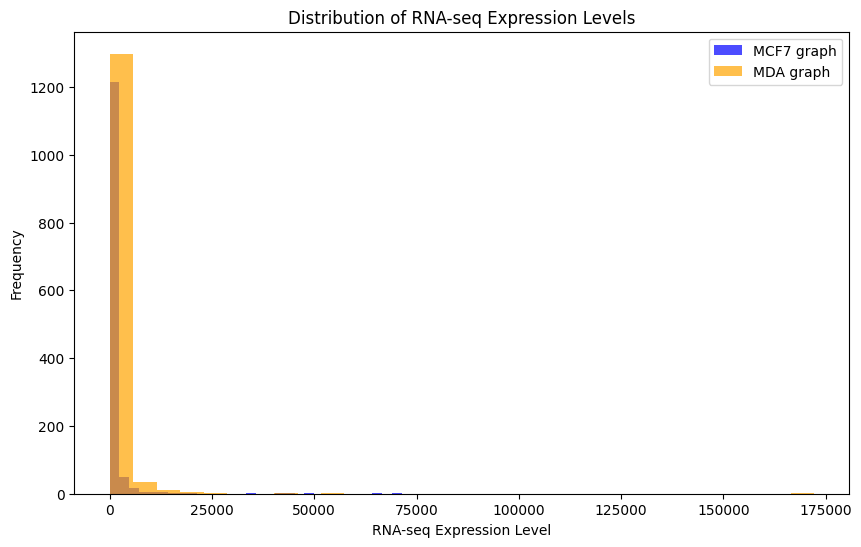

In [70]:
import matplotlib.pyplot as plt

# Plot RNA-seq signals for positive graph
plt.figure(figsize=(10, 6))
plt.hist(signal_mcf7_ppi, bins=30, alpha=0.7, label="MCF7 graph", color='blue')
plt.hist(signal_mda_ppi, bins=30, alpha=0.7, label="MDA graph", color='orange')
plt.xlabel("RNA-seq Expression Level")
plt.ylabel("Frequency")
plt.title("Distribution of RNA-seq Expression Levels")
plt.legend()
plt.show()


# Spectral Clustering
We’ll now perform spectral clustering using the eigenvalues and eigenvectors of the Laplacian matrices for the positive and negative graphs. This helps group nodes (genes) into clusters based on their connectivity patterns and RNA-seq signal variations.

Steps for Spectral Clustering:

A) Compute Eigenvalues and Eigenvectors

Use PyGSP to extract the Fourier basis (eigenvectors of the Laplacian) and corresponding eigenvalues.

B) Cluster Nodes

Use the eigenvectors corresponding to the smallest non-zero eigenvalues for clustering (spectral embedding).

C) Visualize Clustering

Optionally visualize clusters for insights.


# 1. Let's have a combined graph, i.e., we will not split the graph and see whether it works`

In [71]:
import networkx as nx

# Create a single graph to hold all edges
G_combined_MCF7_ppi = nx.DiGraph()

# Add edges to the combined graph with attributes for weight and sign
for u, v, data in G_mcf7_ppi.edges(data=True):
    weight = data.get("weight", 0)
    if weight > 0:
        G_combined_MCF7_ppi.add_edge(u, v, weight=weight, sign="positive")
    elif weight < 0:
        G_combined_MCF7_ppi.add_edge(u, v, weight=abs(weight), sign="negative")  # Use absolute value for negative weights
    else:  # Handle zero-weight edges
        G_combined_MCF7_ppi.add_edge(u, v, weight=weight, sign="neutral")

print(f"Combined Graph: {G_combined_MCF7_ppi.number_of_edges()} edges")

Combined Graph: 418819 edges


In [72]:
import networkx as nx

# Create a single graph to hold all edges
G_combined_MDA_ppi = nx.DiGraph()

# Add edges to the combined graph with attributes for weight and sign
for u, v, data in G_mda_ppi.edges(data=True):
    weight = data.get("weight", 0)
    if weight > 0:
        G_combined_MDA_ppi.add_edge(u, v, weight=weight, sign="positive")
    elif weight < 0:
        G_combined_MDA_ppi.add_edge(u, v, weight=abs(weight), sign="negative")  # Use absolute value for negative weights
    else:  # Handle zero-weight edges
        G_combined_MDA_ppi.add_edge(u, v, weight=weight, sign="neutral")

print(f"Combined MDA Graph: {G_combined_MDA_ppi.number_of_edges()} edges")

Combined MDA Graph: 463461 edges


#2. Handle Disconnected Components
The graphs may contain disconnected components. Ensure that you handle these components separately during Fourier basis computation and clustering.


In [73]:
import networkx as nx
import pygsp as pg
from sklearn.cluster import KMeans
import numpy as np

def process_combined_graph(graph_nx, cell_line_name):
    print(f"Processing {cell_line_name} combined graph.")

    # Identify connected components
    if graph_nx.is_directed():
        connected_components = list(nx.weakly_connected_components(graph_nx))
    else:
        connected_components = list(nx.connected_components(graph_nx))

    all_clusters = []
    for i, component in enumerate(connected_components):
        print(f"Processing component {i+1} with {len(component)} nodes...")

        # Create a subgraph for the component
        subgraph_nx = graph_nx.subgraph(component)
        adjacency_matrix = nx.to_scipy_sparse_array(subgraph_nx, weight="weight")
        subgraph_pygsp = pg.graphs.Graph(adjacency_matrix)

        try:
            # Compute Laplacian and Fourier basis for the subgraph
            subgraph_pygsp.compute_laplacian(lap_type="combinatorial")
            subgraph_pygsp.compute_fourier_basis(recompute=True)

            # Clamp smallest eigenvalue to 0 if it's very close
            if abs(subgraph_pygsp.e[0]) < 1e-10:
                subgraph_pygsp.e[0] = 0

            # Perform clustering on the subgraph
            num_clusters = 3  # Number of clusters
            clusters_subgraph = KMeans(n_clusters=num_clusters).fit_predict(
                subgraph_pygsp.U[:, 1:num_clusters+1]
            )

            # Map cluster labels back to original node indices
            cluster_dict = dict(zip(subgraph_nx.nodes, clusters_subgraph))
            all_clusters.append(cluster_dict)

            print(f"Fourier basis and clustering computed for component {i+1}.")
        except Exception as e:
            print(f"Failed to compute Fourier basis for component {i+1}: {e}")

    # Combine cluster assignments for all components
    combined_clusters = {}
    for cluster_dict in all_clusters:
        combined_clusters.update(cluster_dict)

    return combined_clusters

# Process combined MCF7 graph
clusters_combined_mcf7_ppi = process_combined_graph(G_combined_MCF7_ppi, "MCF7 Combined")

# Process combined MDA graph
clusters_combined_mda_ppi = process_combined_graph(G_combined_MDA_ppi, "MDA Combined")

# Assign cluster labels to nodes in the combined NetworkX graphs
nx.set_node_attributes(G_combined_MCF7_ppi, clusters_combined_mcf7_ppi, "cluster")
nx.set_node_attributes(G_combined_MDA_ppi, clusters_combined_mda_ppi, "cluster")

print("Cluster assignments completed.")

Processing MCF7 Combined combined graph.
Processing component 1 with 1309 nodes...
Fourier basis and clustering computed for component 1.
Processing MDA Combined combined graph.
Processing component 1 with 1354 nodes...
Fourier basis and clustering computed for component 1.
Cluster assignments completed.


# If you want to visualized these graphs, it takes quite long to plot

In [74]:
import matplotlib.pyplot as plt

# Define node positions (e.g., using a layout algorithm)
#pos = nx.spring_layout(G_combined_MCF7_ppi)

# Separate edges by sign
#positive_edges = [(u, v) for u, v, data in G_combined_MCF7_ppi.edges(data=True) if data["sign"] == "positive"]
#negative_edges = [(u, v) for u, v, data in G_combined_MCF7_ppi.edges(data=True) if data["sign"] == "negative"]
#neutral_edges = [(u, v) for u, v, data in G_combined_MCF7_ppi.edges(data=True) if data["sign"] == "neutral"]

# Draw nodes
#nx.draw_networkx_nodes(G_combined_MCF7_ppi, pos, node_size=300, node_color="lightblue")

# Draw edges with different colors
#nx.draw_networkx_edges(G_combined_MCF7_ppi, pos, edgelist=positive_edges, edge_color="green", width=2, label="Positive")
#nx.draw_networkx_edges(G_combined_MCF7_ppi, pos, edgelist=negative_edges, edge_color="red", width=2, label="Negative")
#nx.draw_networkx_edges(G_combined_MCF7_ppi, pos, edgelist=neutral_edges, edge_color="gray", width=2, label="Neutral")

# Draw labels
#nx.draw_networkx_labels(G_combined_MCF7_ppi, pos, font_size=10, font_color="black")

# Add legend
#plt.legend(["Positive Edges", "Negative Edges", "Neutral Edges"])

# Show the plot
#plt.title("Combined Graph with Positive, Negative, and Neutral Edges")
#plt.axis("off")
#plt.show()

In [75]:
import networkx as nx
import pygsp as pg
from networkx import to_scipy_sparse_array

# Function to process a single graph
def process_graph(nx_graph, graph_name):
    print(f"Processing {graph_name} graph...")

    # Remove self-loops
    nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))

    # Check connectivity
    #if nx.is_connected(nx_graph):  # For undirected graphs
     #   print(f"{graph_name} graph is connected.")
    #else:
      #  print(f"{graph_name} graph is disconnected. Processing components separately...")
     #   connected_components = list(nx.connected_components(nx_graph))
      #  for i, component in enumerate(connected_components):
       #     subgraph = nx_graph.subgraph(component)
        #    print(f"Processing component {i+1} with {subgraph.number_of_nodes()} nodes.")

    # Extract adjacency matrix with edge weights
    adjacency_matrix = to_scipy_sparse_array(nx_graph, weight="weight")  # Use "weight" if default

    # Create PyGSP graph
    gsp_graph = pg.graphs.Graph(adjacency_matrix)

    # Display basic graph info
    print(f"PyGSP {graph_name} Graph with {gsp_graph.N} nodes and {gsp_graph.Ne} edges.")

    # Compute Laplacian
    gsp_graph.compute_laplacian(lap_type="combinatorial")

    # Compute Fourier basis
    gsp_graph.compute_fourier_basis(recompute=True)

    # Clamp smallest eigenvalue to 0 if it's very close
    if abs(gsp_graph.e[0]) < 1e-10:
        gsp_graph.e[0] = 0

    # Display first few eigenvalues
    print(f"Eigenvalues ({graph_name}):", gsp_graph.e[:10])

    return gsp_graph

# Process both combined graphs
gsp_graph_mcf7_ppi = process_graph(G_combined_MCF7_ppi, "MCF7 Positive ")

gsp_graph_mda_ppi = process_graph(G_combined_MDA_ppi, "MDA Positive")

# Store results in a dictionary
results = {
    "MCF7 Combined": {"graph": gsp_graph_mcf7_ppi},
    "MDA Combined": {"graph": gsp_graph_mda_ppi},
}

# Optionally, extract eigenvalues and eigenvectors for all graphs
for graph_name, data in results.items():
    gsp_graph = data["graph"]
    results[graph_name]["eigenvalues"] = gsp_graph.e
    results[graph_name]["eigenvectors"] = gsp_graph.U

# Print summary of results
for graph_name, data in results.items():
    print(f"\nSummary for {graph_name}:")
    print(f"Eigenvalues: {data['eigenvalues'][:5]}")  # First 5 eigenvalues

Processing MCF7 Positive  graph...
PyGSP MCF7 Positive  Graph with 1309 nodes and 418819 edges.
Eigenvalues (MCF7 Positive ): [ 0.         18.45801395 18.4751567  19.24903496 19.32888787 19.4507603
 19.66513952 19.82701706 19.84444604 19.89629764]
Processing MDA Positive graph...
PyGSP MDA Positive Graph with 1354 nodes and 463461 edges.
Eigenvalues (MDA Positive): [ 0.         29.79504579 29.97321704 30.05918517 30.57264172 30.82117572
 30.92717268 31.2139313  31.41074221 32.01866253]

Summary for MCF7 Combined:
Eigenvalues: [ 0.         18.45801395 18.4751567  19.24903496 19.32888787]

Summary for MDA Combined:
Eigenvalues: [ 0.         29.79504579 29.97321704 30.05918517 30.57264172]


In [76]:
# Assign Clusters to Nodes
# Assign the cluster labels to nodes in the NetworkX graph for further exploration.

# Assign cluster labels as node attributes for positive and negative graphs
nx.set_node_attributes(G_combined_MCF7_ppi, dict(zip(G_combined_MCF7_ppi.nodes, clusters_combined_mcf7_ppi)), "cluster")
nx.set_node_attributes(G_combined_MDA_ppi, dict(zip(G_combined_MDA_ppi.nodes, clusters_combined_mda_ppi)), "cluster")

# Verify node clusters
print("\nG_combined_mcf7 Clusters:")
for node, data in list(G_combined_MCF7_ppi.nodes(data=True))[:5]:  # First 5 for brevity
    print(node, data)

print("\nG_combined_mda Clusters:")
for node, data in list(G_combined_MDA_ppi.nodes(data=True))[:5]:  # First 5 for brevity
    print(node, data)


G_combined_mcf7 Clusters:
AHR {'cluster': 'AHR'}
ABCA12 {'cluster': 'ABCA12'}
ACKR3 {'cluster': 'ACKR3'}
ACOT4 {'cluster': 'ACOT4'}
ACSL5 {'cluster': 'ACSL5'}

G_combined_mda Clusters:
AHR {'cluster': 'AHR'}
ABCA12 {'cluster': 'ABCA12'}
ACKR3 {'cluster': 'ACKR3'}
ACOT4 {'cluster': 'ACOT4'}
ACSL5 {'cluster': 'ACSL5'}


# Lets try to identify the positive graph with stronger interaction hub depicted with thicker edges

# 1. Identify the Hub Node
# The hub node is likely the node with the highest degree or the strongest total edge weight. You can calculate these metrics:

# Degree Centrality (Number of Connections)

In [87]:
# Get degree centrality for G_positive
degree_centrality = nx.degree_centrality(G_combined_MCF7_ppi)

# Sort nodes by degree centrality
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top nodes
print("Top Nodes by Degree Centrality (Combined MCF7_ppi Graph):")
for node, centrality in sorted_degree[:20]:  # Top 10 nodes
    print(f"Node: {node}, Degree Centrality: {centrality}")


Top Nodes by Degree Centrality (Combined MCF7_ppi Graph):
Node: SOX2, Degree Centrality: 1.4655963302752293
Node: ASCL1, Degree Centrality: 1.0244648318042813
Node: ASCL2, Degree Centrality: 1.0244648318042813
Node: BATF3, Degree Centrality: 1.0244648318042813
Node: CREB5, Degree Centrality: 1.0244648318042813
Node: DMRTA1, Degree Centrality: 1.0244648318042813
Node: ELF5, Degree Centrality: 1.0244648318042813
Node: ESR1, Degree Centrality: 1.0244648318042813
Node: ETS1, Degree Centrality: 1.0244648318042813
Node: ETV1, Degree Centrality: 1.0244648318042813
Node: FOSL1, Degree Centrality: 1.0244648318042813
Node: FOXA2, Degree Centrality: 1.0244648318042813
Node: FOXI3, Degree Centrality: 1.0244648318042813
Node: GRHL2, Degree Centrality: 1.0244648318042813
Node: GSC, Degree Centrality: 1.0244648318042813
Node: HMGA2, Degree Centrality: 1.0244648318042813
Node: HOXA10, Degree Centrality: 1.0244648318042813
Node: HOXA4, Degree Centrality: 1.0244648318042813
Node: HOXC13, Degree Centrali

In [88]:
# Get degree centrality for G_positive
degree_centrality = nx.degree_centrality(G_combined_MDA_ppi)

# Sort nodes by degree centrality
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top nodes
print("Top Nodes by Degree Centrality (Combined MDA_ppi Graph):")
for node, centrality in sorted_degree[:20]:  # Top 10 nodes
    print(f"Node: {node}, Degree Centrality: {centrality}")


Top Nodes by Degree Centrality (Combined MDA_ppi Graph):
Node: SOX2, Degree Centrality: 1.450849963045085
Node: ASCL1, Degree Centrality: 1.0288248337028825
Node: ASCL2, Degree Centrality: 1.0288248337028825
Node: BATF3, Degree Centrality: 1.0288248337028825
Node: CREB5, Degree Centrality: 1.0288248337028825
Node: DMRTA1, Degree Centrality: 1.0288248337028825
Node: ELF5, Degree Centrality: 1.0288248337028825
Node: ESR1, Degree Centrality: 1.0288248337028825
Node: ETS1, Degree Centrality: 1.0288248337028825
Node: ETV1, Degree Centrality: 1.0288248337028825
Node: FOSL1, Degree Centrality: 1.0288248337028825
Node: FOXA2, Degree Centrality: 1.0288248337028825
Node: FOXI3, Degree Centrality: 1.0288248337028825
Node: GRHL2, Degree Centrality: 1.0288248337028825
Node: GSC, Degree Centrality: 1.0288248337028825
Node: HMGA2, Degree Centrality: 1.0288248337028825
Node: HOXA10, Degree Centrality: 1.0288248337028825
Node: HOXA4, Degree Centrality: 1.0288248337028825
Node: HOXC13, Degree Centrality

In [89]:
# Compute strength (sum of edge weights) for each node
strength = {node: sum(data["weight"] for _, _, data in G_combined_MCF7_ppi.edges(node, data=True)) for node in G_combined_MCF7_ppi.nodes()}

# Sort nodes by strength
sorted_strength = sorted(strength.items(), key=lambda x: x[1], reverse=True)

# Display the top nodes
print("\nTop Nodes by Strength (Edge Weights, Positive Graph):")
for node, weight in sorted_strength[:10]:  # Top 10 nodes
    print(f"Node: {node}, Strength (Sum of Weights): {weight}")



Top Nodes by Strength (Edge Weights, Positive Graph):
Node: SOX2, Strength (Sum of Weights): 272.45839071775174
Node: LEF1, Strength (Sum of Weights): 211.2039246356656
Node: ZBTB7B, Strength (Sum of Weights): 190.08023339737917
Node: ZNF235, Strength (Sum of Weights): 186.2514563234892
Node: CREB1, Strength (Sum of Weights): 178.65040391597313
Node: PRDM9, Strength (Sum of Weights): 177.58734633521524
Node: CTCF, Strength (Sum of Weights): 173.53959237369008
Node: NFKB1, Strength (Sum of Weights): 158.64536756640277
Node: ZNF529, Strength (Sum of Weights): 155.26819030985604
Node: RXRA, Strength (Sum of Weights): 152.8365446327219


In [90]:
# Compute strength (sum of edge weights) for each node
strength = {node: sum(data["weight"] for _, _, data in G_combined_MDA_ppi.edges(node, data=True)) for node in G_combined_MDA_ppi.nodes()}

# Sort nodes by strength
sorted_strength = sorted(strength.items(), key=lambda x: x[1], reverse=True)

# Display the top nodes
print("\nTop Nodes by Strength (Edge Weights, Positive Graph):")
for node, weight in sorted_strength[:10]:  # Top 10 nodes
    print(f"Node: {node}, Strength (Sum of Weights): {weight}")



Top Nodes by Strength (Edge Weights, Positive Graph):
Node: SOX2, Strength (Sum of Weights): 315.6013235966641
Node: LEF1, Strength (Sum of Weights): 256.4111787307812
Node: CREB1, Strength (Sum of Weights): 241.93073299824053
Node: RXRA, Strength (Sum of Weights): 197.13071750149885
Node: STAT5A, Strength (Sum of Weights): 180.84635823696476
Node: CTCF, Strength (Sum of Weights): 177.5991197623053
Node: NFKB1, Strength (Sum of Weights): 172.61728057916662
Node: REL, Strength (Sum of Weights): 165.84302491201805
Node: NFKB2, Strength (Sum of Weights): 142.34266683147666
Node: MZF1, Strength (Sum of Weights): 129.00603889012118


# **2. Identify Genes and TFs Connected to the Hub**
# Once you identify the hub node, find all nodes connected to it and analyze their edge weights:

In [94]:
# Get the top hub node (by strength or degree centrality)
top_hub_node_MDA = sorted_strength[0][0]  # Replace with your preferred metric

# Get neighbors (connected nodes) of the hub
neighbors = G_combined_MDA_ppi[top_hub_node_MDA]

print(f"\nNeighbors of Hub Node ({top_hub_node_MDA}):")
for neighbor, edge_data in neighbors.items():
    print(f"Connected Node: {neighbor}, Edge Weight: {edge_data['weight']}")



Neighbors of Hub Node (SOX2):
Connected Node: ABCA12, Edge Weight: 0.10528367082271572
Connected Node: ACKR3, Edge Weight: 0.19546217319545822
Connected Node: ACOT4, Edge Weight: 0.1822168368816205
Connected Node: ACSL5, Edge Weight: 0.0955462436388832
Connected Node: ADAMTS1, Edge Weight: 0.1864099089507104
Connected Node: ADAMTS12, Edge Weight: 0.14011159681698448
Connected Node: ADAMTS16, Edge Weight: 0.24330307241306992
Connected Node: ADAMTS19, Edge Weight: 0.19987210281974477
Connected Node: ADCY1, Edge Weight: 0.20137765541934227
Connected Node: ADCY5, Edge Weight: 0.18176071066870714
Connected Node: ADD2, Edge Weight: 0.20055604126241422
Connected Node: ADGRE1, Edge Weight: 0.1861378419512304
Connected Node: ADGRF5, Edge Weight: 0.20876750875094907
Connected Node: ADGRG5, Edge Weight: 0.17897475710470456
Connected Node: ADRA2C, Edge Weight: 0.24250121468402164
Connected Node: ADRB2, Edge Weight: 0.21386221404907013
Connected Node: AGPAT4, Edge Weight: 0.17069980302761056
Conne

In [97]:
top_hub_node_MCF7 = sorted_degree[0][0]  # Use degree centrality to select the hub
# Get neighbors (connected nodes) of the hub
neighbors = G_combined_MCF7_ppi[top_hub_node_MCF7]

print(f"\nNeighbors of Hub Node ({top_hub_node_MCF7}):")
for neighbor, edge_data in neighbors.items():
    print(f"Connected Node: {neighbor}, Edge Weight: {edge_data['weight']}")


Neighbors of Hub Node (SOX2):
Connected Node: ABCA12, Edge Weight: 0.16354405933867655
Connected Node: ACKR3, Edge Weight: 0.06339998190400542
Connected Node: ACOT4, Edge Weight: 0.042522459683917324
Connected Node: ACSL5, Edge Weight: 0.24412552440608692
Connected Node: ADAMTS1, Edge Weight: 0.08349947802886803
Connected Node: ADAMTS12, Edge Weight: 0.1390974280643158
Connected Node: ADAMTS16, Edge Weight: 0.036939461824562425
Connected Node: ADAMTS19, Edge Weight: 0.10697740850840098
Connected Node: ADCY1, Edge Weight: 0.08649231313211514
Connected Node: ADCY5, Edge Weight: 0.05921590767454399
Connected Node: ADD2, Edge Weight: 0.03854905836304057
Connected Node: ADGRE1, Edge Weight: 0.0500137303604995
Connected Node: ADGRF5, Edge Weight: 0.0687023536213256
Connected Node: ADGRG5, Edge Weight: 0.075959047777576
Connected Node: ADRA2C, Edge Weight: 0.05275203864983191
Connected Node: ADRB2, Edge Weight: 0.09397024210434357
Connected Node: AGPAT4, Edge Weight: 0.08904152722615688
Conn

# **3. Visualize the Hub and Its Connections**
# You can highlight the hub and its neighbors in a graph visualization:

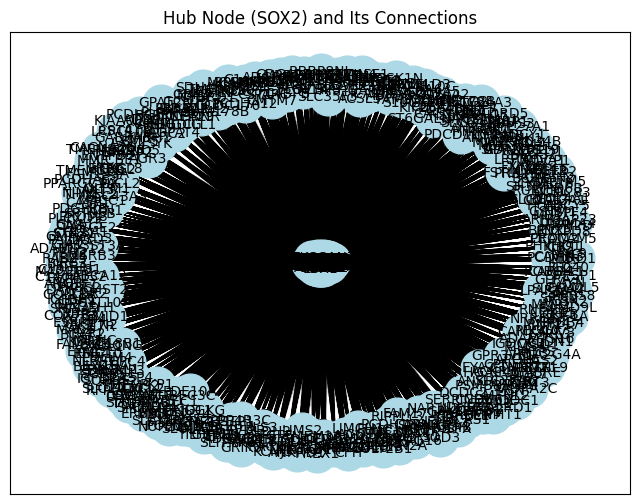

In [93]:
import matplotlib.pyplot as plt

# Get the subgraph for the hub and its neighbors
hub_subgraph_MCF7 = G_combined_MCF7_ppi.subgraph([top_hub_node_MCF7] + list(neighbors.keys()))

# Visualize the subgraph
pos = nx.spring_layout(hub_subgraph_MCF7)  # Layout for visualization
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(hub_subgraph_MCF7, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(hub_subgraph_MCF7, pos, width=[d["weight"] for (_, _, d) in hub_subgraph_MCF7.edges(data=True)])
nx.draw_networkx_labels(hub_subgraph_MCF7, pos, font_size=10)
plt.title(f"Hub Node ({top_hub_node_MCF7}) and Its Connections")
plt.show()


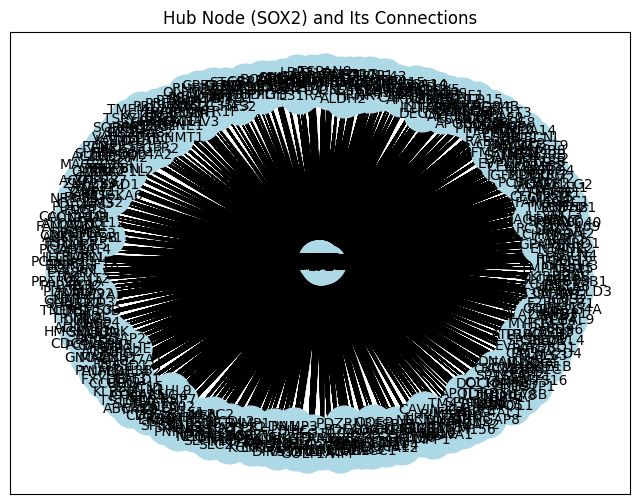

In [95]:
import matplotlib.pyplot as plt

# Get the subgraph for the hub and its neighbors
hub_subgraph_MDA = G_combined_MDA_ppi.subgraph([top_hub_node_MDA] + list(neighbors.keys()))

# Visualize the subgraph
pos = nx.spring_layout(hub_subgraph_MDA)  # Layout for visualization
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(hub_subgraph_MDA, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(hub_subgraph_MDA, pos, width=[d["weight"] for (_, _, d) in hub_subgraph_MDA.edges(data=True)])
nx.draw_networkx_labels(hub_subgraph_MDA, pos, font_size=10)
plt.title(f"Hub Node ({top_hub_node_MDA}) and Its Connections")
plt.show()


# **4. Export Hub Connections for Further Analysis**
# If you want to analyze this data outside Python, export the hub’s connections to a file:

In [98]:
import pandas as pd

# Create a DataFrame for the hub's connections
hub_connections_MCF7= pd.DataFrame({
    "TF": [top_hub_node_MCF7] * len(neighbors),
    "Gene": list(neighbors.keys()),
    "Edge Weight": [data["weight"] for _, data in neighbors.items()]
})

# Save to CSV
hub_connections_MCF7.to_csv("hub_connections_MCF7.csv", index=False)
print("\nHub connections exported to 'hub_connections_MCF7.csv'")





Hub connections exported to 'hub_connections_MCF7.csv'


In [99]:
import pandas as pd

# Create a DataFrame for the hub's connections
hub_connections_MDA= pd.DataFrame({
    "TF": [top_hub_node_MDA] * len(neighbors),
    "Gene": list(neighbors.keys()),
    "Edge Weight": [data["weight"] for _, data in neighbors.items()]
})

# Save to CSV
hub_connections_MDA.to_csv("hub_connections_MDA.csv", index=False)
print("\nHub connections exported to 'hub_connections_MDA.csv'")



Hub connections exported to 'hub_connections_MDA.csv'
